# 05: Multiple-Patch Model Training
This script implements uniform patching, patch-level training with sample weights, and painting-level aggregation.

## 1. Imports & Dependencies
(imports os, numpy, torch, torchvision, timm, PIL, GroupShuffleSplit)

In [1]:
#1. Import dependencies
import os, numpy as np, torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset
from torchvision import transforms
import timm
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import GroupShuffleSplit
import torch.nn.utils as U
from collections import defaultdict, Counter
import json
from datetime import datetime
from torch.utils.data import Dataset
from torchvision import transforms
import torch # For dummy tensor in __getitem__ error handling
from timm.scheduler import CosineLRScheduler
import pandas as pd
from pathlib import Path

## 2. Define dataset class producing all patches
(class MultiPatchDataset)

In [2]:
class MultiPatchDataset(Dataset):
    def __init__(self, root_dir, target_size=256, imitation_weight=1.0):
        self.root_dir = root_dir
        self.target_size = target_size
        self.imitation_weight = imitation_weight
        self.defined_classes = ['authentic', 'imitation'] # authentic=0, imitation=1
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.defined_classes)}
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        print(f"Dataset initialized. Root: '{self.root_dir}', Class mapping: {self.class_to_idx}")

        # Store patch metadata instead of actual images
        self.patch_info = []  # Will store (img_path, label, painting_id, crop_box)
        self.all_patches = []  # Keep for backward compatibility - will store (None, label, painting_id)
        self._prepare_data()

        self.transform = transforms.Compose([
            transforms.Resize((self.target_size, self.target_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def _prepare_data(self):
        painting_id_counter = 0
        for class_name in self.defined_classes:
            class_path = os.path.join(self.root_dir, class_name)
            if not os.path.isdir(class_path):
                print(f"Warning: Class directory not found: {class_path}")
                continue

            label = self.class_to_idx[class_name]
            
            image_files = sorted([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            if not image_files:
                print(f"Warning: No image files found in {class_path}")
                continue

            for img_filename in image_files:
                img_path = os.path.join(class_path, img_filename)
                current_painting_id = painting_id_counter

                try:
                    # Only open image to get dimensions, don't keep it in memory
                    with Image.open(img_path) as img:
                        w, h = img.size

                    if w == 0 or h == 0:
                        print(f"Warning: Image {img_path} has zero dimension, skipping.")
                        continue

                    max_dim = max(w, h)
                    if max_dim > 1024:
                        grid_size = 4  # 4x4 patches
                    elif max_dim >= 512:
                        grid_size = 2  # 2x2 patches
                    else:
                        grid_size = 1  # 1x1 patch

                    patch_width = w // grid_size
                    patch_height = h // grid_size

                    if patch_width == 0 or patch_height == 0:
                         print(f"Warning: Calculated patch size is zero for {img_path} (w={w},h={h},grid={grid_size}), skipping.")
                         continue

                    # Store crop coordinates instead of actual patches
                    for i in range(grid_size):
                        for j in range(grid_size):
                            left = j * patch_width
                            upper = i * patch_height
                            right = (j + 1) * patch_width if (j + 1) < grid_size else w
                            bottom = (i + 1) * patch_height if (i + 1) < grid_size else h
                            
                            if (right - left) > 0 and (bottom - upper) > 0:
                                crop_box = (left, upper, right, bottom)
                                self.patch_info.append((img_path, label, current_painting_id, crop_box))
                                # Keep backward compatibility with all_patches
                                self.all_patches.append((None, label, current_painting_id))
                            else:
                                print(f"Warning: Generated empty patch for {img_path} at grid ({i},{j}), skipping.")
                    
                    painting_id_counter += 1

                except UnidentifiedImageError:
                    print(f"Warning: Cannot identify image file {img_path}, skipping.")
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")
        
        if not self.patch_info:
            print(f"Warning: No patches were generated. Check dataset structure in '{self.root_dir}', paths, and image files.")
        else:
            print(f"Generated {len(self.patch_info)} patch coordinates from {painting_id_counter} paintings.")

    def __len__(self):
        return len(self.patch_info)

    def __getitem__(self, idx):
        img_path, label, painting_id, crop_box = self.patch_info[idx]
        
        try:
            # Load and crop image on-demand
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                patch_img = img.crop(crop_box)
            
            transformed_patch = self.transform(patch_img)
            
        except Exception as e:
            print(f"Error loading/transforming patch (index {idx}, painting_id {painting_id}): {e}")
            # Return a dummy tensor
            transformed_patch = torch.zeros((3, self.target_size, self.target_size), dtype=torch.float32)
            
        return transformed_patch, label, painting_id

## 3. Define Device, Prepare Dataset & Splits, Calculate Class Weights

In [3]:

# Define device at the beginning of this cell
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

root_dir = '/kaggle/input/vangogh-run7/run_7'  # adjust path as needed
ds = MultiPatchDataset(root_dir, target_size=256, imitation_weight=1.0)
groups = [pid for _, _, pid in ds.all_patches]

# splitting with GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(ds.all_patches, groups=groups))

print(f"Train samples: {len(train_idx)} | Val samples: {len(val_idx)}")
print(f"Classes: {list(ds.class_to_idx.keys())}")


csv_path = "/kaggle/input/csv-file/vg_imgs_aug11_Adi_updated.csv"  

def track_split_during_processing(csv_path, root_dir, ds, train_idx, val_idx):
    
    print("Updating Excel file with train/val split...")
    df = pd.read_csv(csv_path)
    
    df['run_7_train_val_images'] = ''
    
    painting_id_to_info = {}
    painting_id_counter = 0
    
    for class_name in ds.defined_classes:
        class_path = Path(root_dir) / class_name
        if not class_path.is_dir():
            continue
            
        image_files = sorted([f for f in class_path.iterdir() 
                            if f.suffix.lower() in ('.png', '.jpg', '.jpeg')])
        
        for img_file in image_files:
            painting_id_to_info[painting_id_counter] = img_file.name
            painting_id_counter += 1
    
    train_painting_ids = {ds.all_patches[idx][2] for idx in train_idx}
    val_painting_ids = {ds.all_patches[idx][2] for idx in val_idx}
    
    train_filenames = {painting_id_to_info[pid] for pid in train_painting_ids if pid in painting_id_to_info}
    val_filenames = {painting_id_to_info[pid] for pid in val_painting_ids if pid in painting_id_to_info}

    for idx, row in df.iterrows():
        image_filename = row['image']
        if image_filename in train_filenames:
            df.loc[idx, 'run_7_train_val_images'] = 'train'
        elif image_filename in val_filenames:
            df.loc[idx, 'run_7_train_val_images'] = 'val'
    
    # Save updated file
    output_path = '/kaggle/working/vg_imgs_aug11_Adi_updated_with_train_val_split.csv'
    df.to_csv(output_path, index=False)
    
    split_counts = df['run_7_train_val_images'].value_counts()
    print(f"Updated Excel saved to: {output_path}")
    print(f"Train/Val split: {dict(split_counts)}")
    
    return output_path

updated_excel = track_split_during_processing(
    csv_path="/kaggle/input/csv-file/vg_imgs_aug11_Adi_updated.csv",  
    root_dir=root_dir,
    ds=ds,
    train_idx=train_idx,
    val_idx=val_idx
)

# Create subset datasets
train_dataset = Subset(ds, train_idx)
val_dataset = Subset(ds, val_idx)

# sample weights for imbalance
train_labels_for_sampler = np.array([ds.all_patches[i][1] for i in train_idx])
weights = [ds.imitation_weight if label == ds.class_to_idx.get('imitation', 1) else 1 for label in train_labels_for_sampler]
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4) # Corrected: uses val_dataset

# Calculate class_weights for loss_fn
train_labels_for_class_weights = [ds.all_patches[i][1] for i in train_idx]
class_counts = Counter(train_labels_for_class_weights)
num_classes = len(ds.class_to_idx)

# ---- START DEBUG PRINTS ----
print(f"DEBUG: ds.class_to_idx: {ds.class_to_idx}")
print(f"DEBUG: num_classes: {num_classes}")
print(f"DEBUG: train_labels_for_class_weights (first 20): {train_labels_for_class_weights[:20]}")
print(f"DEBUG: Unique labels in train_labels_for_class_weights: {np.unique(train_labels_for_class_weights)}")
print(f"DEBUG: class_counts: {class_counts}")
# ---- END DEBUG PRINTS ----

weights_list = [0.0] * num_classes 
print(f"DEBUG: initial weights_list (length {len(weights_list)}): {weights_list}")


for class_idx, count in class_counts.items():
    # ---- START DEBUG PRINTS FOR LOOP ----
    print(f"DEBUG LOOP: Processing class_idx: {class_idx} (type: {type(class_idx)}), count: {count}")
    # ---- END DEBUG PRINTS FOR LOOP ----
    if count > 0: # Avoid division by zero if a class is somehow not in train_labels
        if class_idx < 0 or class_idx >= num_classes:
            print(f"ERROR DEBUG: class_idx {class_idx} is out of range for weights_list of length {num_classes}")
        weights_list[class_idx] = len(train_labels_for_class_weights) / (num_classes * count)
    else: # if a class has 0 samples in the training set, assign a default weight of 1.0 or handle as error
        if class_idx < 0 or class_idx >= num_classes:
            print(f"ERROR DEBUG (else branch): class_idx {class_idx} is out of range for weights_list of length {num_classes}")
        weights_list[class_idx] = 1.0 # Or some other default/strategy

class_weights = torch.tensor(weights_list, dtype=torch.float).to(device)
print(f"Calculated class weights: {class_weights.tolist()}")

Using device: cuda
Dataset initialized. Root: '/kaggle/input/vangogh-run7/run_7', Class mapping: {'authentic': 0, 'imitation': 1}


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Generated 21060 patch coordinates from 1773 paintings.
Train samples: 16916 | Val samples: 4144
Classes: ['authentic', 'imitation']
Updating Excel file with train/val split...
Updated Excel saved to: /kaggle/working/vg_imgs_aug11_Adi_updated_with_train_val_split.csv
Train/Val split: {'train': 1417, '': 1251, 'val': 352}
DEBUG: ds.class_to_idx: {'authentic': 0, 'imitation': 1}
DEBUG: num_classes: 2
DEBUG: train_labels_for_class_weights (first 20): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
DEBUG: Unique labels in train_labels_for_class_weights: [0 1]
DEBUG: class_counts: Counter({0: 8702, 1: 8214})
DEBUG: initial weights_list (length 2): [0.0, 0.0]
DEBUG LOOP: Processing class_idx: 0 (type: <class 'int'>), count: 8702
DEBUG LOOP: Processing class_idx: 1 (type: <class 'int'>), count: 8214
Calculated class weights: [0.9719604849815369, 1.0297054052352905]


## 4. Model Setup (EfficientNet & Swin) with Activation Hooks

In [4]:
# 4. Model Setup (EfficientNet & Swin with DLR for Swin)
print("--- Setting up models and optimizers ---")

import torch
import torch.nn as nn

models = {}
models['efficientnet'] = timm.create_model('efficientnet_b5', pretrained=True, num_classes=2).to(device)
models['swin'] = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=2, img_size=256, drop_rate=0.5,drop_path_rate=0.4).to(device) 

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.01) 


# --- Differential Learning Rate Setup for EfficientNet ---
print("\n--- Setting up EfficientNet with Differential Learning Rates ---")
efficientnet_model = models['efficientnet']

# Define learning rates for different parts of EfficientNet
lr_backbone_early = 1e-7    
lr_backbone_mid = 3e-7       
lr_backbone_late = 8e-7     
lr_classifier = 1e-6       

try:
    # Get all named parameters
    all_params = list(efficientnet_model.named_parameters())
    
    # Separate parameters into groups based on layer names
    early_params = []      # stem, blocks.0-2
    mid_params = []        # blocks.3-5  
    late_params = []       # blocks.6+, conv_head, bn2
    classifier_params = []  # classifier
    
    for name, param in all_params:
        if 'classifier' in name:
            classifier_params.append(param)
        elif any(layer in name for layer in ['conv_stem', 'bn1', 'blocks.0', 'blocks.1', 'blocks.2']):
            early_params.append(param)
        elif any(layer in name for layer in ['blocks.3', 'blocks.4', 'blocks.5']):
            mid_params.append(param)
        else:  # blocks.6+, conv_head, bn2, etc.
            late_params.append(param)
    
    # Create parameter groups with different learning rates
    param_groups = []
    
    if early_params:
        param_groups.append({
            'params': early_params, 
            'lr': lr_backbone_early, 
            'name': 'efficientnet_early_backbone'
        })
        print(f"  Early backbone params: {len(early_params)} tensors, LR: {lr_backbone_early:.2e}")
    
    if mid_params:
        param_groups.append({
            'params': mid_params, 
            'lr': lr_backbone_mid, 
            'name': 'efficientnet_mid_backbone'
        })
        print(f"  Mid backbone params: {len(mid_params)} tensors, LR: {lr_backbone_mid:.2e}")
    
    if late_params:
        param_groups.append({
            'params': late_params, 
            'lr': lr_backbone_late, 
            'name': 'efficientnet_late_backbone'
        })
        print(f"  Late backbone params: {len(late_params)} tensors, LR: {lr_backbone_late:.2e}")
    
    if classifier_params:
        param_groups.append({
            'params': classifier_params, 
            'lr': lr_classifier, 
            'name': 'efficientnet_classifier'
        })
        print(f"  Classifier params: {len(classifier_params)} tensors, LR: {lr_classifier:.2e}")
    
    # Create optimizer with parameter groups
    if param_groups:
        eff_optimizer = torch.optim.AdamW(param_groups, weight_decay=1e-2)
        print("  EfficientNet Differential Learning Rate optimizer configured successfully.")
    else:
        print("  Warning: No parameter groups found. Using single LR fallback.")
        eff_optimizer = torch.optim.AdamW(efficientnet_model.parameters(), lr=1e-6, weight_decay=1e-2)

except Exception as e:
    print(f"  Error setting up EfficientNet DLR: {e}")
    print("  Falling back to single learning rate for EfficientNet.")
    eff_optimizer = torch.optim.AdamW(efficientnet_model.parameters(), lr=1e-6, weight_decay=1e-2)


# --- Differential Learning Rate Setup for Swin Transformer ---
swin_model_instance = models['swin']

# Define Learning Rates for the initial (Frozen Backbone) phase
lr_head_frozen_swin = 3e-5       # Initial LR for the Swin head
lr_backbone_frozen_swin = 0.0    # Backbone is frozen

try:
    # For swin_tiny_patch4_window7_224, the classifier is typically 'head'
    head_params_swin = list(swin_model_instance.head.parameters())
    head_param_ids_swin = {id(p) for p in head_params_swin}
    backbone_params_swin = [p for p in swin_model_instance.parameters() if id(p) not in head_param_ids_swin]

    if not backbone_params_swin:
        print("Warning: Swin backbone parameters list is empty. Check model structure ('head'). Falling back.")
        # Fallback: all params trainable with head_lr
        for param in swin_model_instance.parameters():
            param.requires_grad = True
        swin_optimizer = torch.optim.AdamW(swin_model_instance.parameters(), lr=lr_head_frozen_swin, weight_decay=1e-2)
    else:
        # Freeze backbone layers initially
        for param in backbone_params_swin:
            param.requires_grad = False
        # Ensure head is trainable
        for param in head_params_swin:
            param.requires_grad = True

        swin_optimizer = torch.optim.AdamW([
            {'params': backbone_params_swin, 'lr': lr_backbone_frozen_swin, 'name': 'swin_backbone'},
            {'params': head_params_swin, 'lr': lr_head_frozen_swin, 'name': 'swin_head'}
        ], weight_decay=1e-2) # Using 1e-2 weight decay as per your original Swin optimizer
        print("Swin Transformer Optimizer (Frozen Backbone Phase - DLR) configured.")

except AttributeError:
    print("Error: swin_model_instance.head not found. Cannot separate head/backbone for Swin DLRs automatically.")
    print("Falling back to a single learning rate for all Swin parameters.")
    for param in swin_model_instance.parameters(): # Ensure all params are trainable if fallback
        param.requires_grad = True
    swin_optimizer = torch.optim.AdamW(swin_model_instance.parameters(), lr=lr_head_frozen_swin, weight_decay=1e-2)

optimizers = {
    'efficientnet': eff_optimizer,
    'swin': swin_optimizer
}

# Print optimizer details for verification
for model_name, optimizer in optimizers.items():
    print(f"\nOptimizer for {model_name}:")
    if optimizer: # Check if optimizer was successfully created
        for i, param_group in enumerate(optimizer.param_groups):
            group_name = param_group.get('name', f'group_{i}')
            num_params_in_group = sum(p.numel() for p in param_group['params'] if p.requires_grad)
            total_params_in_group = sum(p.numel() for p in param_group['params'])
            print(f"  Group: {group_name}, LR: {param_group['lr']}, Trainable Params: {num_params_in_group}/{total_params_in_group}, Num Tensors: {len(param_group['params'])}")
            if len(param_group['params']) > 0:
                 print(f"    Sample param requires_grad: {param_group['params'][0].requires_grad}")
    else:
        print(f"  Optimizer for {model_name} not configured (likely due to an error).")
print("--- Model and optimizer setup complete ---")

--- Setting up models and optimizers ---


model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]


--- Setting up EfficientNet with Differential Learning Rates ---
  Early backbone params: 215 tensors, LR: 1.00e-07
  Mid backbone params: 253 tensors, LR: 3.00e-07
  Late backbone params: 36 tensors, LR: 8.00e-07
  Classifier params: 2 tensors, LR: 1.00e-06
  EfficientNet Differential Learning Rate optimizer configured successfully.
Swin Transformer Optimizer (Frozen Backbone Phase - DLR) configured.

Optimizer for efficientnet:
  Group: efficientnet_early_backbone, LR: 1e-07, Trainable Params: 530528/530528, Num Tensors: 215
    Sample param requires_grad: True
  Group: efficientnet_mid_backbone, LR: 3e-07, Trainable Params: 17028612/17028612, Num Tensors: 253
    Sample param requires_grad: True
  Group: efficientnet_late_backbone, LR: 8e-07, Trainable Params: 10781644/10781644, Num Tensors: 36
    Sample param requires_grad: True
  Group: efficientnet_classifier, LR: 1e-06, Trainable Params: 4098/4098, Num Tensors: 2
    Sample param requires_grad: True

Optimizer for swin:
  Grou

## 5. Logging & Model‐Saving Setup
(make log directory, define timestamp, model_save_paths, log_paths, and log_metrics function)

In [5]:
 
# Ensure log directory exists
os.makedirs('/kaggle/working/Training Data', exist_ok=True)
now_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Define save paths (log_paths removed)
model_save_paths = {
    "efficientnet": f"/kaggle/working/model/efficientnet_b5_finetuned_{now_str}_run7.pth",
    "swin": f"/kaggle/working/model/swin_tiny_patch4_window7_224_finetuned_{now_str}_run7.pth"
}

## 6. Function: save_training_results
(defines saving detailed training/validation metrics to JSON)

In [6]:
def save_training_results(model_name, train_metrics, val_metrics, now_str):
    """Save detailed training results to a JSON file"""
    results = {
        "model_name": model_name,
        "timestamp": now_str,
        "training": train_metrics,
        "validation": val_metrics
    }
    json_path = f"/kaggle/working/Training Data/{model_name}_results_{now_str}_run7.json"
    with open(json_path, 'w') as f:
        json.dump(results, f, indent=4)
    print(f"Detailed results saved to {json_path}")

In [7]:
# 6a. Enhanced train_one_epoch with console logging
def train_one_epoch(model, loader, optimizer, epoch=None, print_every=10):
    model.train()
    total_loss, all_preds, all_labels = 0, [], []

    for batch_idx, (x, y, _) in enumerate(loader, start=1):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()

        # clip & capture the norm in one step
        #grad_norm = U.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # Use a higher max_norm for Swin, standard for others
        if hasattr(model, 'default_cfg') and 'swin' in model.default_cfg.get('architecture', '').lower():
            grad_norm = U.clip_grad_norm_(model.parameters(), max_norm=5.0)
        else:
            grad_norm = U.clip_grad_norm_(model.parameters(), max_norm=1.0)
        #print(f"Gradient magnitude: {grad_norm:.6f}")

        optimizer.step()
        total_loss += loss.item() * x.size(0)

        preds = out.argmax(dim=1).cpu().tolist()
        all_preds .extend(preds)
        all_labels.extend(y.cpu().tolist())

        if epoch is not None and batch_idx % print_every == 0:
            print(f"Epoch {epoch+1} | Batch {batch_idx}/{len(loader)} | Loss {loss.item():.6f}")

    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, all_labels, all_preds

## 7. Evaluation with painting-level aggregation
(eval_dataset using defaultdict to average patch logits)

In [8]:
# 7. Evaluation with painting-level aggregation

def eval_dataset_with_loss(model, loader, loss_fn):
    model.eval()
    group_logits = defaultdict(list)
    group_labels = {}
    total_loss = 0
    total_samples = 0
    
    with torch.no_grad():
        for x, y, pid in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            
            # Calculate loss for this batch
            batch_loss = loss_fn(logits, y)
            total_loss += batch_loss.item() * x.size(0)
            total_samples += x.size(0)
            
            # Continue with painting-level aggregation
            logits_cpu = logits.cpu()
            for lg, yy, id_ in zip(logits_cpu, y.cpu(), pid):
                group_logits[id_].append(lg)
                group_labels[id_] = int(yy)

    # Calculate average loss
    avg_loss = total_loss / total_samples
    
    # Sample predictions (first 5)
    for pid, lgs in list(group_logits.items())[:5]:
        avg = torch.stack(lgs).mean(0)
        print(f"Painting {pid}: logits={avg.tolist()}, pred={int(avg.argmax())}, true={group_labels[pid]}")

    # Class balance print
    y_true = list(group_labels.values())
    print(f"Validation class distribution: {sum(y_true)}/{len(y_true)} positives")

    # Compute painting-level accuracy
    y_pred = [int(torch.stack(lgs).mean(0).argmax()) for lgs in group_logits.values()]
    acc = sum(yt==yp for yt, yp in zip(y_true, y_pred)) / len(y_true)
    
    return acc, avg_loss

## 8. Training loop (patch-level)
(defines train_one_epoch and loops over models to train, log, save checkpoints, and call save_training_results)

--- Configuring Schedulers ---
  Configured ReduceLROnPlateau for 'efficientnet'.
  Scheduler for 'swin' will be initialized during unfreeze.
--- Schedulers configured ---

--- Verifying Initial Swin Model State (Pre-Epoch 0) ---
  Checking requires_grad for Swin model params...
  Verifying Swin optimizer groups LRs and param_requires_grad...
  Swin initial state verification complete.

--- Starting Training for 30 Epochs ---

===== EPOCH 1/30 =====

Training swin for Epoch 1...
  Current LRs for swin:
    Group 'swin_backbone': 0.00e+00
    Group 'swin_head': 3.00e-05


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  

Epoch 1 | Batch 50/1058 | Loss 0.682234


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 1 | Batch 100/1058 | Loss 0.588433


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 | Batch 150/1058 | Loss 0.660870


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 | Batch 200/1058 | Loss 0.617513


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 | Batch 250/1058 | Loss 0.642438


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 | Batch 300/1058 | Loss 0.576464
Epoch 1 | Batch 350/1058 | Loss 0.755011


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 | Batch 400/1058 | Loss 0.705904


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 | Batch 450/1058 | Loss 0.594162


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 | Batch 500/1058 | Loss 0.760718
Epoch 1 | Batch 550/1058 | Loss 0.510062
Epoch 1 | Batch 600/1058 | Loss 0.495954
Epoch 1 | Batch 650/1058 | Loss 0.645058


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 | Batch 700/1058 | Loss 0.613740
Epoch 1 | Batch 750/1058 | Loss 0.540917
Epoch 1 | Batch 800/1058 | Loss 0.536464
Epoch 1 | Batch 850/1058 | Loss 0.444990
Epoch 1 | Batch 900/1058 | Loss 0.602017


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 | Batch 950/1058 | Loss 0.528686
Epoch 1 | Batch 1000/1058 | Loss 0.477741


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 | Batch 1050/1058 | Loss 0.456477
Validating swin for Epoch 1...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 1/30 | Train Loss: 0.585431 | Val Acc: 0.807915


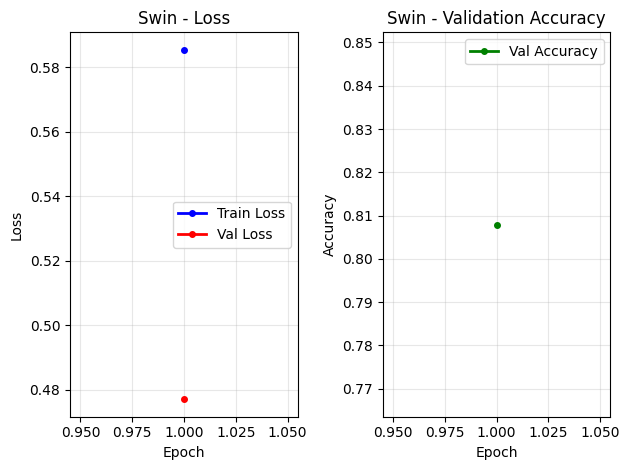


===== EPOCH 2/30 =====

Training swin for Epoch 2...
  Current LRs for swin:
    Group 'swin_backbone': 0.00e+00
    Group 'swin_head': 3.00e-05


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 | Batch 50/1058 | Loss 0.532796


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 | Batch 100/1058 | Loss 0.436416


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 | Batch 150/1058 | Loss 0.520488


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 | Batch 200/1058 | Loss 0.587231


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 | Batch 250/1058 | Loss 0.356615


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 2 | Batch 300/1058 | Loss 0.456408


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 | Batch 350/1058 | Loss 0.471637


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 2 | Batch 400/1058 | Loss 0.429342
Epoch 2 | Batch 450/1058 | Loss 0.560117


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 | Batch 500/1058 | Loss 0.666965


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 | Batch 550/1058 | Loss 0.418124


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 | Batch 600/1058 | Loss 0.296480
Epoch 2 | Batch 650/1058 | Loss 0.497106


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 | Batch 700/1058 | Loss 0.322093
Epoch 2 | Batch 750/1058 | Loss 0.408101
Epoch 2 | Batch 800/1058 | Loss 0.490075
Epoch 2 | Batch 850/1058 | Loss 0.359671
Epoch 2 | Batch 900/1058 | Loss 0.523932
Epoch 2 | Batch 950/1058 | Loss 0.289253
Epoch 2 | Batch 1000/1058 | Loss 0.294402
Epoch 2 | Batch 1050/1058 | Loss 0.311690
Validating swin for Epoch 2...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 2/30 | Train Loss: 0.455707 | Val Acc: 0.836873


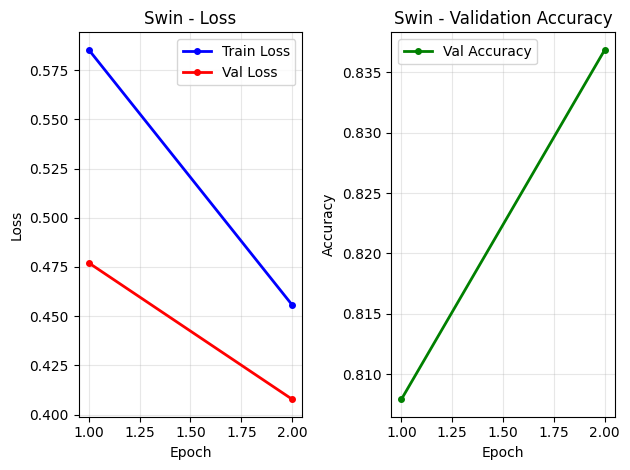


===== EPOCH 3/30 =====

Training swin for Epoch 3...
  Current LRs for swin:
    Group 'swin_backbone': 0.00e+00
    Group 'swin_head': 3.00e-05


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 3 | Batch 50/1058 | Loss 0.362300


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 | Batch 100/1058 | Loss 0.363458


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 | Batch 150/1058 | Loss 0.402991


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 | Batch 200/1058 | Loss 0.332661


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 | Batch 250/1058 | Loss 0.292691


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 | Batch 300/1058 | Loss 0.538689


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 | Batch 350/1058 | Loss 0.492598


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 | Batch 400/1058 | Loss 0.393179
Epoch 3 | Batch 450/1058 | Loss 0.481730
Epoch 3 | Batch 500/1058 | Loss 0.330472
Epoch 3 | Batch 550/1058 | Loss 0.410240


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 | Batch 600/1058 | Loss 0.350812


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 | Batch 650/1058 | Loss 0.278139
Epoch 3 | Batch 700/1058 | Loss 0.349500
Epoch 3 | Batch 750/1058 | Loss 0.374037


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 | Batch 800/1058 | Loss 0.146506
Epoch 3 | Batch 850/1058 | Loss 0.472317
Epoch 3 | Batch 900/1058 | Loss 0.420892
Epoch 3 | Batch 950/1058 | Loss 0.371422


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 | Batch 1000/1058 | Loss 0.534682
Epoch 3 | Batch 1050/1058 | Loss 0.454069
Validating swin for Epoch 3...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 3/30 | Train Loss: 0.411431 | Val Acc: 0.848938


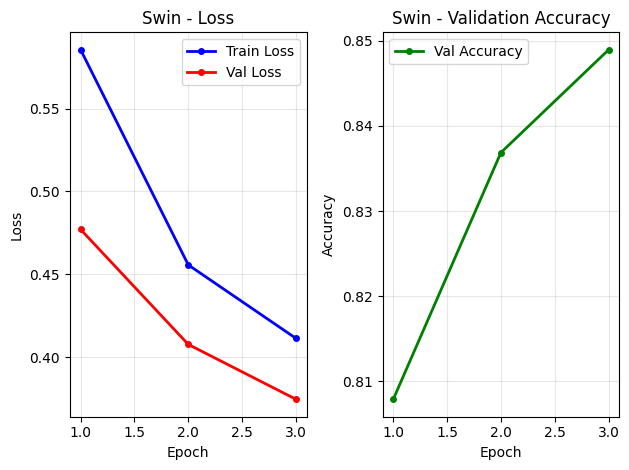


===== EPOCH 4/30 =====

Training swin for Epoch 4...
  Current LRs for swin:
    Group 'swin_backbone': 0.00e+00
    Group 'swin_head': 3.00e-05


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 4 | Batch 50/1058 | Loss 0.331681


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 4 | Batch 100/1058 | Loss 0.349053


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 | Batch 150/1058 | Loss 0.324204


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 | Batch 200/1058 | Loss 0.252665


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 | Batch 250/1058 | Loss 0.369735


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 | Batch 300/1058 | Loss 0.371502


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 | Batch 350/1058 | Loss 0.250502


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 | Batch 400/1058 | Loss 0.384447
Epoch 4 | Batch 450/1058 | Loss 0.681218


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 | Batch 500/1058 | Loss 0.218556


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 | Batch 550/1058 | Loss 0.376288
Epoch 4 | Batch 600/1058 | Loss 0.479541


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 | Batch 650/1058 | Loss 0.254323


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 | Batch 700/1058 | Loss 0.413189
Epoch 4 | Batch 750/1058 | Loss 0.240558
Epoch 4 | Batch 800/1058 | Loss 0.699279


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 | Batch 850/1058 | Loss 0.496464
Epoch 4 | Batch 900/1058 | Loss 0.357953
Epoch 4 | Batch 950/1058 | Loss 0.393995
Epoch 4 | Batch 1000/1058 | Loss 0.516720
Epoch 4 | Batch 1050/1058 | Loss 0.452661
Validating swin for Epoch 4...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 4/30 | Train Loss: 0.377353 | Val Acc: 0.856178


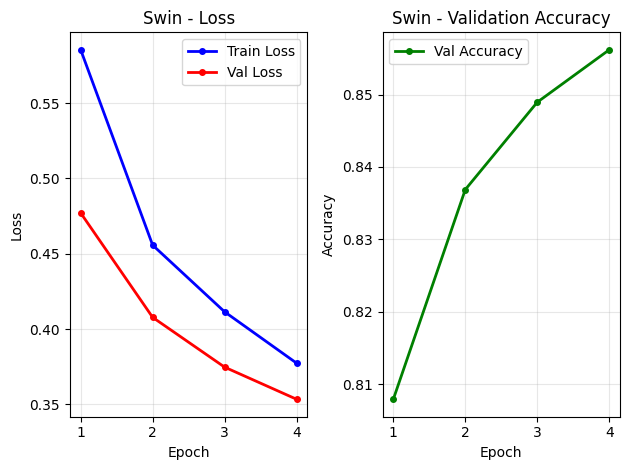


===== EPOCH 5/30 =====

Training swin for Epoch 5...
  Current LRs for swin:
    Group 'swin_backbone': 0.00e+00
    Group 'swin_head': 3.00e-05


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 5 | Batch 50/1058 | Loss 0.438325


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 5 | Batch 100/1058 | Loss 0.333653


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 | Batch 150/1058 | Loss 0.351569


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 | Batch 200/1058 | Loss 0.329211


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 | Batch 250/1058 | Loss 0.394828


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 | Batch 300/1058 | Loss 0.440630


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 | Batch 350/1058 | Loss 0.274826
Epoch 5 | Batch 400/1058 | Loss 0.443004


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 | Batch 450/1058 | Loss 0.396638


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 | Batch 500/1058 | Loss 0.343025


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 | Batch 550/1058 | Loss 0.430280
Epoch 5 | Batch 600/1058 | Loss 0.341881


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 | Batch 650/1058 | Loss 0.300790
Epoch 5 | Batch 700/1058 | Loss 0.343964
Epoch 5 | Batch 750/1058 | Loss 0.366719
Epoch 5 | Batch 800/1058 | Loss 0.584677


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 | Batch 850/1058 | Loss 0.505460


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 | Batch 900/1058 | Loss 0.435065
Epoch 5 | Batch 950/1058 | Loss 0.421368


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 | Batch 1000/1058 | Loss 0.455106
Epoch 5 | Batch 1050/1058 | Loss 0.306844
Validating swin for Epoch 5...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 5/30 | Train Loss: 0.360584 | Val Acc: 0.860763


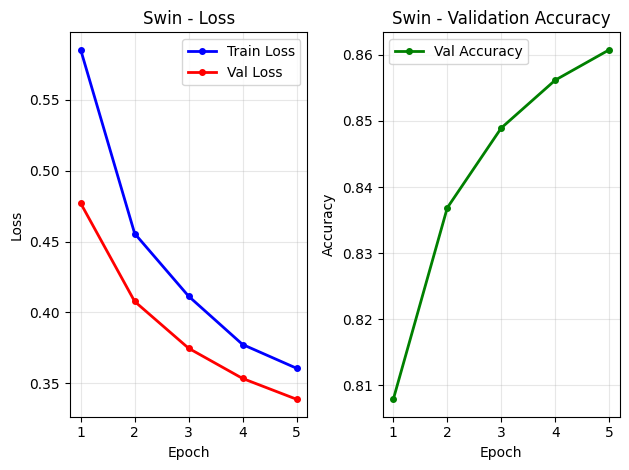


===== EPOCH 6/30 =====

-- Epoch 6: Unfreezing Swin Transformer backbone and adjusting LRs for fine-tuning. --
  Setting requires_grad=True for all Swin model parameters...
    All Swin model parameters set to requires_grad=True.
  LR for Swin group 'swin_backbone' set to: 1.00e-06
  LR for Swin group 'swin_head' set to: 5.00e-06
  Successfully updated LRs for Swin optimizer groups.
  Initializing CosineLRScheduler for Swin fine-tuning...
  Swin CosineLRScheduler initialized for 25 fine-tuning epochs.
-- Swin unfreezing and LR adjustment complete. --

Training swin for Epoch 6...
  Current LRs for swin:
    Group 'swin_backbone': 1.00e-06
    Group 'swin_head': 1.00e-06


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 | Batch 50/1058 | Loss 0.386338


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 | Batch 100/1058 | Loss 0.382246


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch 6 | Batch 150/1058 | Loss 0.340912


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 | Batch 200/1058 | Loss 0.354936


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 | Batch 250/1058 | Loss 0.426136


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 | Batch 300/1058 | Loss 0.388188


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 | Batch 350/1058 | Loss 0.354354


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 | Batch 400/1058 | Loss 0.420072


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 | Batch 450/1058 | Loss 0.353301


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 | Batch 500/1058 | Loss 0.440574
Epoch 6 | Batch 550/1058 | Loss 0.373858
Epoch 6 | Batch 600/1058 | Loss 0.395062


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 | Batch 650/1058 | Loss 0.222973
Epoch 6 | Batch 700/1058 | Loss 0.130438
Epoch 6 | Batch 750/1058 | Loss 0.266012
Epoch 6 | Batch 800/1058 | Loss 0.317107


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 | Batch 850/1058 | Loss 0.273704
Epoch 6 | Batch 900/1058 | Loss 0.429584
Epoch 6 | Batch 950/1058 | Loss 0.404054
Epoch 6 | Batch 1000/1058 | Loss 0.255034
Epoch 6 | Batch 1050/1058 | Loss 0.118329
Validating swin for Epoch 6...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 6/30 | Train Loss: 0.300458 | Val Acc: 0.902027


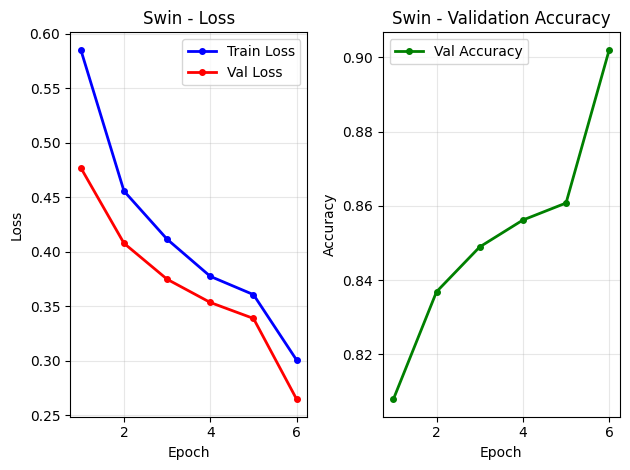


===== EPOCH 7/30 =====

Training swin for Epoch 7...
  Current LRs for swin:
    Group 'swin_backbone': 1.00e-06
    Group 'swin_head': 1.00e-06


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch 7 | Batch 50/1058 | Loss 0.291601


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 | Batch 100/1058 | Loss 0.524616


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 | Batch 150/1058 | Loss 0.388793


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 | Batch 200/1058 | Loss 0.139510


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 | Batch 250/1058 | Loss 0.116836


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 | Batch 300/1058 | Loss 0.204649


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 | Batch 350/1058 | Loss 0.177771


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 | Batch 400/1058 | Loss 0.313777


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 | Batch 450/1058 | Loss 0.525357


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 | Batch 500/1058 | Loss 0.346752


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 | Batch 550/1058 | Loss 0.214924


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 | Batch 600/1058 | Loss 0.532270
Epoch 7 | Batch 650/1058 | Loss 0.089767
Epoch 7 | Batch 700/1058 | Loss 0.123531


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 | Batch 750/1058 | Loss 0.140855
Epoch 7 | Batch 800/1058 | Loss 0.307676
Epoch 7 | Batch 850/1058 | Loss 0.219046


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 | Batch 900/1058 | Loss 0.136324
Epoch 7 | Batch 950/1058 | Loss 0.131702
Epoch 7 | Batch 1000/1058 | Loss 0.348372
Epoch 7 | Batch 1050/1058 | Loss 0.157111
Validating swin for Epoch 7...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 7/30 | Train Loss: 0.241658 | Val Acc: 0.916988


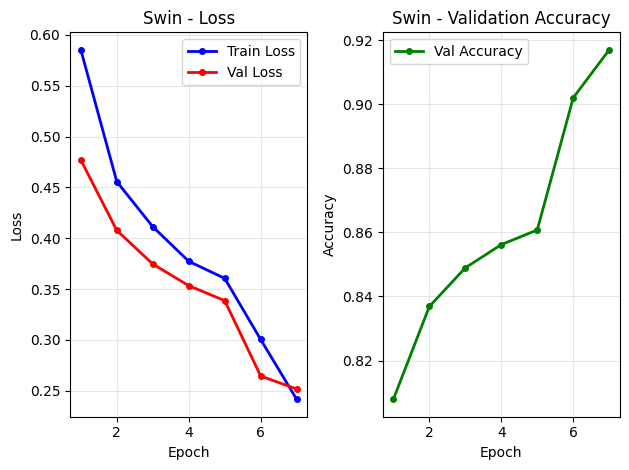


===== EPOCH 8/30 =====

Training swin for Epoch 8...
  Current LRs for swin:
    Group 'swin_backbone': 9.98e-07
    Group 'swin_head': 4.98e-06


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8 | Batch 50/1058 | Loss 0.408688


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8 | Batch 100/1058 | Loss 0.264162


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8 | Batch 150/1058 | Loss 0.100985


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8 | Batch 200/1058 | Loss 0.330327


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 8 | Batch 250/1058 | Loss 0.177661


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8 | Batch 300/1058 | Loss 0.243576


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8 | Batch 350/1058 | Loss 0.206116
Epoch 8 | Batch 400/1058 | Loss 0.128478


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8 | Batch 450/1058 | Loss 0.160344
Epoch 8 | Batch 500/1058 | Loss 0.069160


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8 | Batch 550/1058 | Loss 0.099575


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8 | Batch 600/1058 | Loss 0.064435


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8 | Batch 650/1058 | Loss 0.146532
Epoch 8 | Batch 700/1058 | Loss 0.227521
Epoch 8 | Batch 750/1058 | Loss 0.254946
Epoch 8 | Batch 800/1058 | Loss 0.144698
Epoch 8 | Batch 850/1058 | Loss 0.399454


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8 | Batch 900/1058 | Loss 0.228681
Epoch 8 | Batch 950/1058 | Loss 0.187703
Epoch 8 | Batch 1000/1058 | Loss 0.071737
Epoch 8 | Batch 1050/1058 | Loss 0.237996
Validating swin for Epoch 8...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 8/30 | Train Loss: 0.221358 | Val Acc: 0.925434


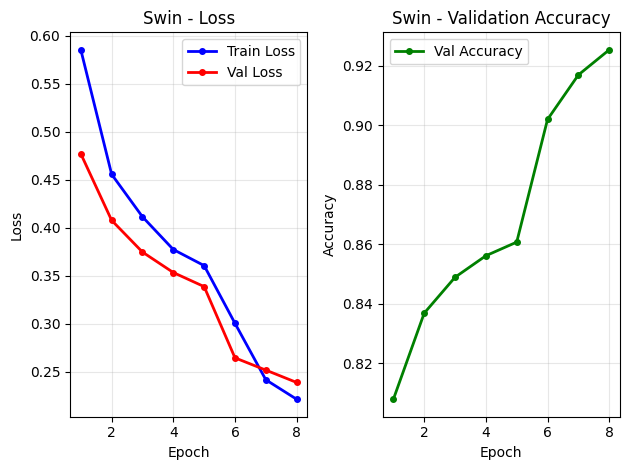


===== EPOCH 9/30 =====

Training swin for Epoch 9...
  Current LRs for swin:
    Group 'swin_backbone': 9.92e-07
    Group 'swin_head': 4.93e-06


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 9 | Batch 50/1058 | Loss 0.100388


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 9 | Batch 100/1058 | Loss 0.071855


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 9 | Batch 150/1058 | Loss 0.129823


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 9 | Batch 200/1058 | Loss 0.245691


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 9 | Batch 250/1058 | Loss 0.309669


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 9 | Batch 300/1058 | Loss 0.381695


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 9 | Batch 350/1058 | Loss 0.089719


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 9 | Batch 400/1058 | Loss 0.252365


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 9 | Batch 450/1058 | Loss 0.292347
Epoch 9 | Batch 500/1058 | Loss 0.708952


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 9 | Batch 550/1058 | Loss 0.249640
Epoch 9 | Batch 600/1058 | Loss 0.173521
Epoch 9 | Batch 650/1058 | Loss 0.046429
Epoch 9 | Batch 700/1058 | Loss 0.078998


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 9 | Batch 750/1058 | Loss 0.226179
Epoch 9 | Batch 800/1058 | Loss 0.045129


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 9 | Batch 850/1058 | Loss 0.203430
Epoch 9 | Batch 900/1058 | Loss 0.265677
Epoch 9 | Batch 950/1058 | Loss 0.272993
Epoch 9 | Batch 1000/1058 | Loss 0.082070
Epoch 9 | Batch 1050/1058 | Loss 0.087188
Validating swin for Epoch 9...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 9/30 | Train Loss: 0.204988 | Val Acc: 0.931226


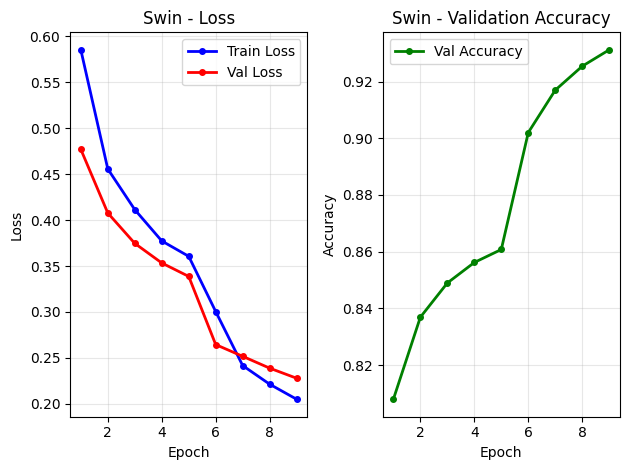


===== EPOCH 10/30 =====

Training swin for Epoch 10...
  Current LRs for swin:
    Group 'swin_backbone': 9.82e-07
    Group 'swin_head': 4.84e-06


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 10 | Batch 50/1058 | Loss 0.331503


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 10 | Batch 100/1058 | Loss 0.260343


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 10 | Batch 150/1058 | Loss 0.215047


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 10 | Batch 200/1058 | Loss 0.058224


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 10 | Batch 250/1058 | Loss 0.182484
Epoch 10 | Batch 300/1058 | Loss 0.192971


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 10 | Batch 350/1058 | Loss 0.293414
Epoch 10 | Batch 400/1058 | Loss 0.175344


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 10 | Batch 450/1058 | Loss 0.340084


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 10 | Batch 500/1058 | Loss 0.054363


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 10 | Batch 550/1058 | Loss 0.206704


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 10 | Batch 600/1058 | Loss 0.339790
Epoch 10 | Batch 650/1058 | Loss 0.044417
Epoch 10 | Batch 700/1058 | Loss 0.040929
Epoch 10 | Batch 750/1058 | Loss 0.208440
Epoch 10 | Batch 800/1058 | Loss 0.069350
Epoch 10 | Batch 850/1058 | Loss 0.204343
Epoch 10 | Batch 900/1058 | Loss 0.041204
Epoch 10 | Batch 950/1058 | Loss 0.108089
Epoch 10 | Batch 1000/1058 | Loss 0.093378
Epoch 10 | Batch 1050/1058 | Loss 0.246559
Validating swin for Epoch 10...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 10/30 | Train Loss: 0.185414 | Val Acc: 0.936776


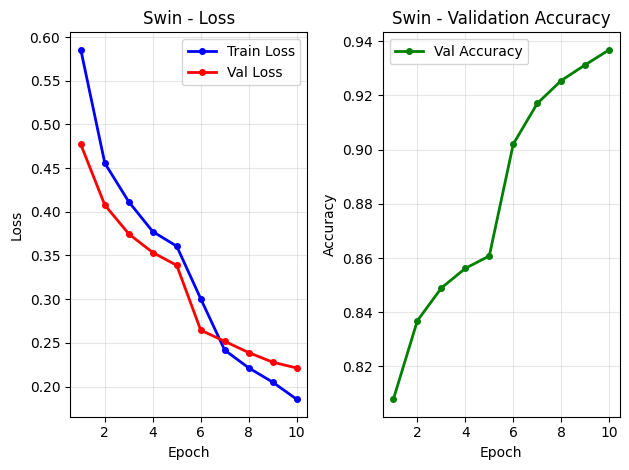


===== EPOCH 11/30 =====

Training swin for Epoch 11...
  Current LRs for swin:
    Group 'swin_backbone': 9.69e-07
    Group 'swin_head': 4.72e-06


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11 | Batch 50/1058 | Loss 0.321106


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 11 | Batch 100/1058 | Loss 0.108073


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11 | Batch 150/1058 | Loss 0.469587


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11 | Batch 200/1058 | Loss 0.210367


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11 | Batch 250/1058 | Loss 0.260752


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11 | Batch 300/1058 | Loss 0.247902
Epoch 11 | Batch 350/1058 | Loss 0.059487
Epoch 11 | Batch 400/1058 | Loss 0.071809


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11 | Batch 450/1058 | Loss 0.111725


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11 | Batch 500/1058 | Loss 0.114974


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11 | Batch 550/1058 | Loss 0.322904
Epoch 11 | Batch 600/1058 | Loss 0.099202
Epoch 11 | Batch 650/1058 | Loss 0.103697
Epoch 11 | Batch 700/1058 | Loss 0.128219


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11 | Batch 750/1058 | Loss 0.225767
Epoch 11 | Batch 800/1058 | Loss 0.146641
Epoch 11 | Batch 850/1058 | Loss 0.516731
Epoch 11 | Batch 900/1058 | Loss 0.382625


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11 | Batch 950/1058 | Loss 0.412282
Epoch 11 | Batch 1000/1058 | Loss 0.061419
Epoch 11 | Batch 1050/1058 | Loss 0.157709
Validating swin for Epoch 11...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 11/30 | Train Loss: 0.184622 | Val Acc: 0.937741


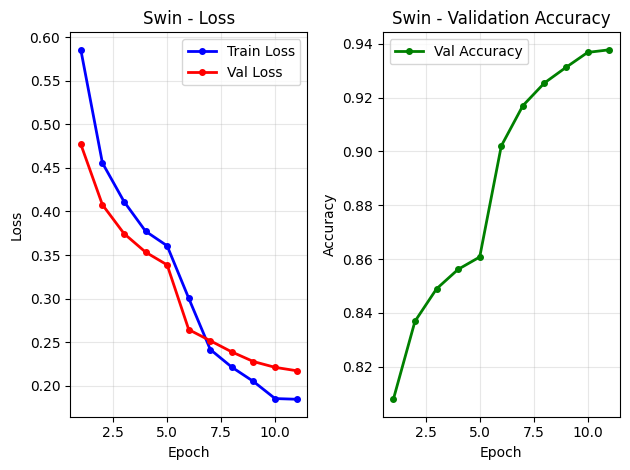


===== EPOCH 12/30 =====

Training swin for Epoch 12...
  Current LRs for swin:
    Group 'swin_backbone': 9.52e-07
    Group 'swin_head': 4.57e-06


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DO

Epoch 12 | Batch 50/1058 | Loss 0.170694


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 12 | Batch 100/1058 | Loss 0.070558


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12 | Batch 150/1058 | Loss 0.111907


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12 | Batch 200/1058 | Loss 0.109520


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12 | Batch 250/1058 | Loss 0.044831


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12 | Batch 300/1058 | Loss 0.330162


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12 | Batch 350/1058 | Loss 0.289387
Epoch 12 | Batch 400/1058 | Loss 0.251565


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12 | Batch 450/1058 | Loss 0.092379


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12 | Batch 500/1058 | Loss 0.057865


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12 | Batch 550/1058 | Loss 0.128438


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12 | Batch 600/1058 | Loss 0.070268
Epoch 12 | Batch 650/1058 | Loss 0.059976
Epoch 12 | Batch 700/1058 | Loss 0.072975


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12 | Batch 750/1058 | Loss 0.049828
Epoch 12 | Batch 800/1058 | Loss 0.214237
Epoch 12 | Batch 850/1058 | Loss 0.103640
Epoch 12 | Batch 900/1058 | Loss 0.317885
Epoch 12 | Batch 950/1058 | Loss 0.127151
Epoch 12 | Batch 1000/1058 | Loss 0.249817
Epoch 12 | Batch 1050/1058 | Loss 0.060736
Validating swin for Epoch 12...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 12/30 | Train Loss: 0.166455 | Val Acc: 0.940154


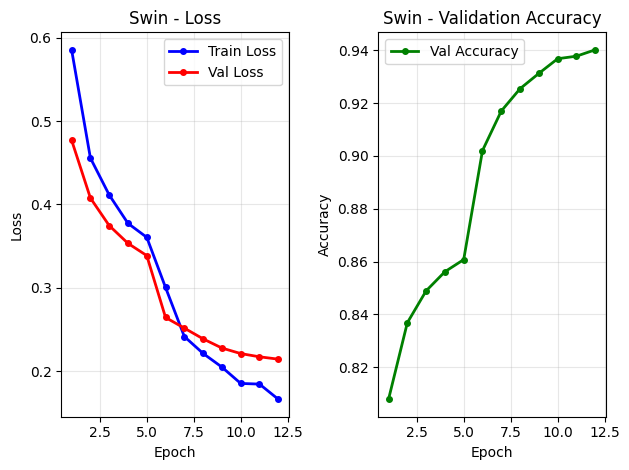


===== EPOCH 13/30 =====

Training swin for Epoch 13...
  Current LRs for swin:
    Group 'swin_backbone': 9.32e-07
    Group 'swin_head': 4.39e-06


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 50/1058 | Loss 0.113305


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 100/1058 | Loss 0.190423


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 150/1058 | Loss 0.178947


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 13 | Batch 200/1058 | Loss 0.052638


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 250/1058 | Loss 0.233645


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 300/1058 | Loss 0.170527


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 350/1058 | Loss 0.080141


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 400/1058 | Loss 0.178911


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 450/1058 | Loss 0.070793


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 500/1058 | Loss 0.158064


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 550/1058 | Loss 0.244552
Epoch 13 | Batch 600/1058 | Loss 0.258415


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 650/1058 | Loss 0.052879


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 700/1058 | Loss 0.073435


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 750/1058 | Loss 0.113001
Epoch 13 | Batch 800/1058 | Loss 0.102744


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 850/1058 | Loss 0.137988
Epoch 13 | Batch 900/1058 | Loss 0.051315


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13 | Batch 950/1058 | Loss 0.109813
Epoch 13 | Batch 1000/1058 | Loss 0.163722
Epoch 13 | Batch 1050/1058 | Loss 0.181587
Validating swin for Epoch 13...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 13/30 | Train Loss: 0.162151 | Val Acc: 0.940154


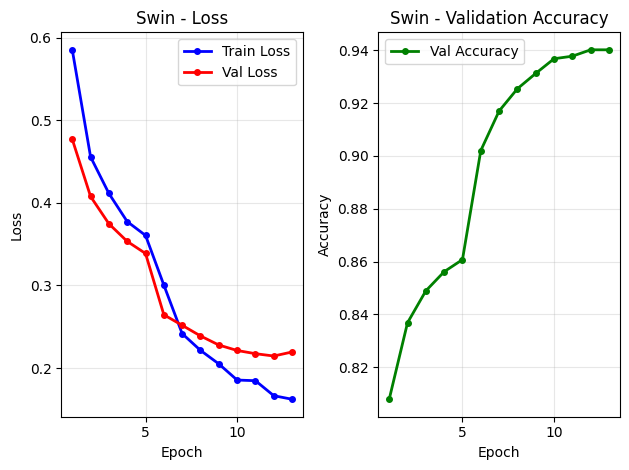


===== EPOCH 14/30 =====

Training swin for Epoch 14...
  Current LRs for swin:
    Group 'swin_backbone': 9.09e-07
    Group 'swin_head': 4.18e-06


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14 | Batch 50/1058 | Loss 0.142810


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 14 | Batch 100/1058 | Loss 0.094120


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14 | Batch 150/1058 | Loss 0.112284


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14 | Batch 200/1058 | Loss 0.099794


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DO

Epoch 14 | Batch 250/1058 | Loss 0.317148


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14 | Batch 300/1058 | Loss 0.145289


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14 | Batch 350/1058 | Loss 0.042586


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14 | Batch 400/1058 | Loss 0.067865


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14 | Batch 450/1058 | Loss 0.047875
Epoch 14 | Batch 500/1058 | Loss 0.063266
Epoch 14 | Batch 550/1058 | Loss 0.092738
Epoch 14 | Batch 600/1058 | Loss 0.089385
Epoch 14 | Batch 650/1058 | Loss 0.070177


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14 | Batch 700/1058 | Loss 0.042340
Epoch 14 | Batch 750/1058 | Loss 0.866035


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14 | Batch 800/1058 | Loss 0.059623
Epoch 14 | Batch 850/1058 | Loss 0.055904
Epoch 14 | Batch 900/1058 | Loss 0.120317


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14 | Batch 950/1058 | Loss 0.049315


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14 | Batch 1000/1058 | Loss 0.194030
Epoch 14 | Batch 1050/1058 | Loss 0.118749
Validating swin for Epoch 14...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 14/30 | Train Loss: 0.159582 | Val Acc: 0.945705


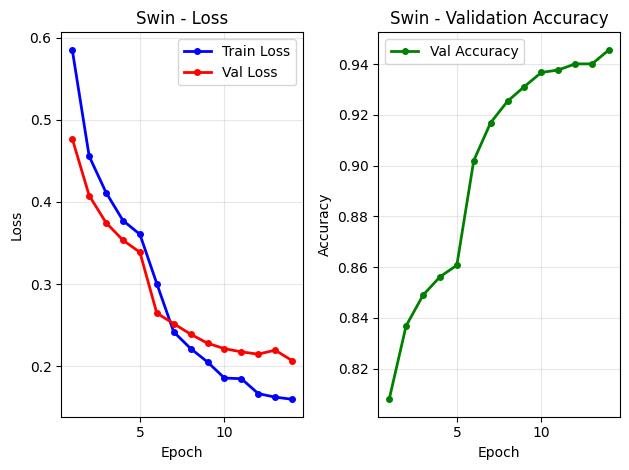


===== EPOCH 15/30 =====

Training swin for Epoch 15...
  Current LRs for swin:
    Group 'swin_backbone': 8.84e-07
    Group 'swin_head': 3.96e-06


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 15 | Batch 50/1058 | Loss 0.053911


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15 | Batch 100/1058 | Loss 0.085047


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 15 | Batch 150/1058 | Loss 0.182174


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15 | Batch 200/1058 | Loss 0.160478


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15 | Batch 250/1058 | Loss 0.301479
Epoch 15 | Batch 300/1058 | Loss 0.202088


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15 | Batch 350/1058 | Loss 0.053478


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15 | Batch 400/1058 | Loss 0.056940


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15 | Batch 450/1058 | Loss 0.316309
Epoch 15 | Batch 500/1058 | Loss 0.154359


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15 | Batch 550/1058 | Loss 0.518892


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15 | Batch 600/1058 | Loss 0.098548
Epoch 15 | Batch 650/1058 | Loss 0.254058


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15 | Batch 700/1058 | Loss 0.139055


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15 | Batch 750/1058 | Loss 0.040557
Epoch 15 | Batch 800/1058 | Loss 0.050653
Epoch 15 | Batch 850/1058 | Loss 0.048112
Epoch 15 | Batch 900/1058 | Loss 0.037173
Epoch 15 | Batch 950/1058 | Loss 0.135719
Epoch 15 | Batch 1000/1058 | Loss 0.049801
Epoch 15 | Batch 1050/1058 | Loss 0.061172
Validating swin for Epoch 15...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 15/30 | Train Loss: 0.150777 | Val Acc: 0.945222


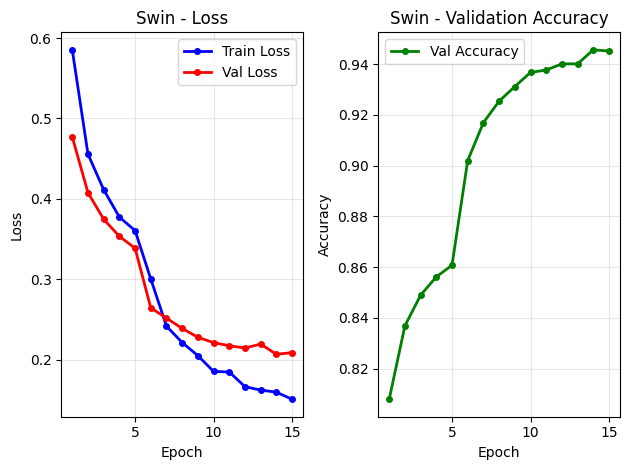


===== EPOCH 16/30 =====

Training swin for Epoch 16...
  Current LRs for swin:
    Group 'swin_backbone': 8.56e-07
    Group 'swin_head': 3.71e-06


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch 16 | Batch 50/1058 | Loss 0.117024


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch 16 | Batch 100/1058 | Loss 0.271032


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 16 | Batch 150/1058 | Loss 0.040584


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16 | Batch 200/1058 | Loss 0.065992


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16 | Batch 250/1058 | Loss 0.185877


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16 | Batch 300/1058 | Loss 0.456078


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16 | Batch 350/1058 | Loss 0.109050


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16 | Batch 400/1058 | Loss 0.045022
Epoch 16 | Batch 450/1058 | Loss 0.047340


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16 | Batch 500/1058 | Loss 0.040471


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16 | Batch 550/1058 | Loss 0.120751
Epoch 16 | Batch 600/1058 | Loss 0.349360
Epoch 16 | Batch 650/1058 | Loss 0.104119
Epoch 16 | Batch 700/1058 | Loss 0.152736


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16 | Batch 750/1058 | Loss 0.318626
Epoch 16 | Batch 800/1058 | Loss 0.339164
Epoch 16 | Batch 850/1058 | Loss 0.159627
Epoch 16 | Batch 900/1058 | Loss 0.079883
Epoch 16 | Batch 950/1058 | Loss 0.186034
Epoch 16 | Batch 1000/1058 | Loss 0.068934


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16 | Batch 1050/1058 | Loss 0.049578
Validating swin for Epoch 16...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 16/30 | Train Loss: 0.147357 | Val Acc: 0.948359


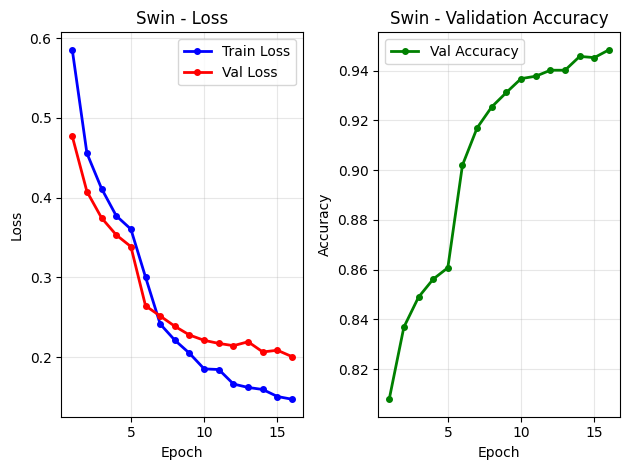


===== EPOCH 17/30 =====

Training swin for Epoch 17...
  Current LRs for swin:
    Group 'swin_backbone': 8.27e-07
    Group 'swin_head': 3.45e-06


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch 17 | Batch 50/1058 | Loss 0.059962


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 17 | Batch 100/1058 | Loss 0.481736


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 17 | Batch 150/1058 | Loss 0.434068


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 17 | Batch 200/1058 | Loss 0.088386


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 17 | Batch 250/1058 | Loss 0.139940


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 17 | Batch 300/1058 | Loss 0.089775


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 17 | Batch 350/1058 | Loss 0.370816


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 17 | Batch 400/1058 | Loss 0.201874
Epoch 17 | Batch 450/1058 | Loss 0.137330


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 17 | Batch 500/1058 | Loss 0.064940
Epoch 17 | Batch 550/1058 | Loss 0.110689
Epoch 17 | Batch 600/1058 | Loss 0.143097


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 17 | Batch 650/1058 | Loss 0.410905


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 17 | Batch 700/1058 | Loss 0.230847


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 17 | Batch 750/1058 | Loss 0.039477
Epoch 17 | Batch 800/1058 | Loss 0.162262
Epoch 17 | Batch 850/1058 | Loss 0.070499
Epoch 17 | Batch 900/1058 | Loss 0.077822
Epoch 17 | Batch 950/1058 | Loss 0.050172
Epoch 17 | Batch 1000/1058 | Loss 0.098922
Epoch 17 | Batch 1050/1058 | Loss 0.044587
Validating swin for Epoch 17...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 17/30 | Train Loss: 0.133438 | Val Acc: 0.948359


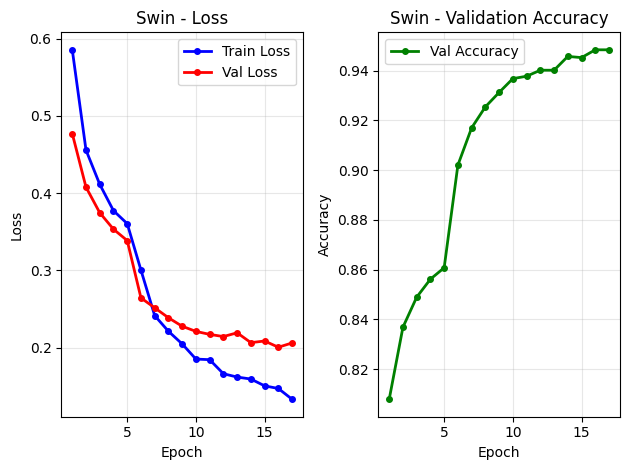


===== EPOCH 18/30 =====

Training swin for Epoch 18...
  Current LRs for swin:
    Group 'swin_backbone': 7.97e-07
    Group 'swin_head': 3.17e-06


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch 18 | Batch 50/1058 | Loss 0.151945


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 18 | Batch 100/1058 | Loss 0.129620


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 18 | Batch 150/1058 | Loss 0.163378


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 18 | Batch 200/1058 | Loss 0.285650


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 18 | Batch 250/1058 | Loss 0.271286


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 18 | Batch 300/1058 | Loss 0.353819


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 18 | Batch 350/1058 | Loss 0.120628


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 18 | Batch 400/1058 | Loss 0.038616


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 18 | Batch 450/1058 | Loss 0.090726
Epoch 18 | Batch 500/1058 | Loss 0.115290
Epoch 18 | Batch 550/1058 | Loss 0.063550
Epoch 18 | Batch 600/1058 | Loss 0.047005


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 18 | Batch 650/1058 | Loss 0.112942


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 18 | Batch 700/1058 | Loss 0.196613


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 18 | Batch 750/1058 | Loss 0.135823
Epoch 18 | Batch 800/1058 | Loss 0.132693
Epoch 18 | Batch 850/1058 | Loss 0.595854
Epoch 18 | Batch 900/1058 | Loss 0.141530
Epoch 18 | Batch 950/1058 | Loss 0.038793
Epoch 18 | Batch 1000/1058 | Loss 0.199708


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 18 | Batch 1050/1058 | Loss 0.042617
Validating swin for Epoch 18...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 18/30 | Train Loss: 0.132357 | Val Acc: 0.949807


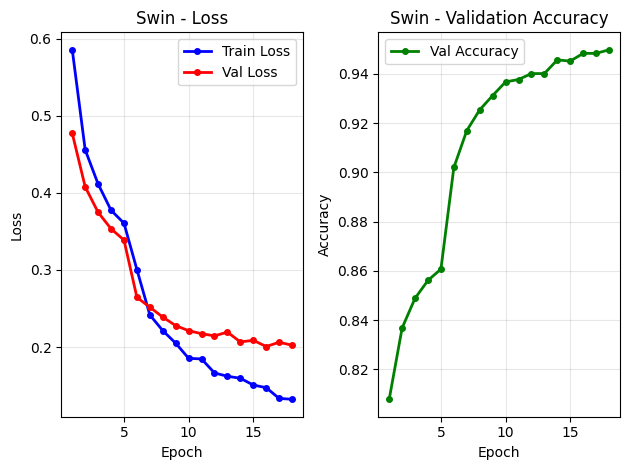


===== EPOCH 19/30 =====

Training swin for Epoch 19...
  Current LRs for swin:
    Group 'swin_backbone': 7.66e-07
    Group 'swin_head': 2.89e-06


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch 19 | Batch 50/1058 | Loss 0.291487


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 100/1058 | Loss 0.394760


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 19 | Batch 150/1058 | Loss 0.058143


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 200/1058 | Loss 0.038945


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 250/1058 | Loss 0.038172
Epoch 19 | Batch 300/1058 | Loss 0.049453


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 350/1058 | Loss 0.302443


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 400/1058 | Loss 0.192122


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 450/1058 | Loss 0.329376


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 500/1058 | Loss 0.048059


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 550/1058 | Loss 0.099533


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 600/1058 | Loss 0.083329
Epoch 19 | Batch 650/1058 | Loss 0.049539


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 700/1058 | Loss 0.057296
Epoch 19 | Batch 750/1058 | Loss 0.042137


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 800/1058 | Loss 0.365448
Epoch 19 | Batch 850/1058 | Loss 0.049968
Epoch 19 | Batch 900/1058 | Loss 0.198672
Epoch 19 | Batch 950/1058 | Loss 0.466683


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 1000/1058 | Loss 0.042865


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 | Batch 1050/1058 | Loss 0.082732
Validating swin for Epoch 19...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 19/30 | Train Loss: 0.129453 | Val Acc: 0.952220


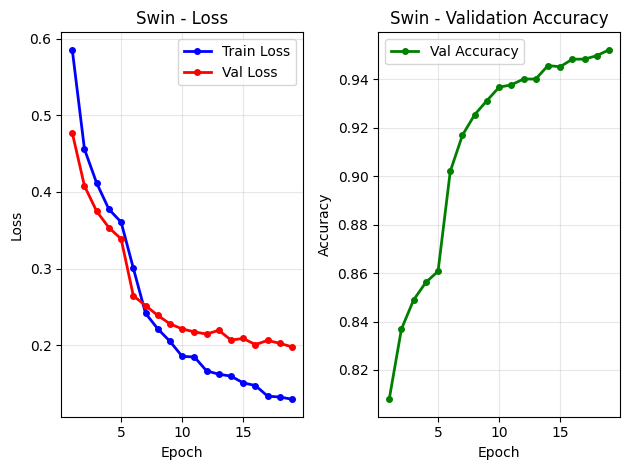


===== EPOCH 20/30 =====

Training swin for Epoch 20...
  Current LRs for swin:
    Group 'swin_backbone': 7.34e-07
    Group 'swin_head': 2.61e-06


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 20 | Batch 50/1058 | Loss 0.188905


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 20 | Batch 100/1058 | Loss 0.111596


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 20 | Batch 150/1058 | Loss 0.149811


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 20 | Batch 200/1058 | Loss 0.044827


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 20 | Batch 250/1058 | Loss 0.037993
Epoch 20 | Batch 300/1058 | Loss 0.186013


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 20 | Batch 350/1058 | Loss 0.233881


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 20 | Batch 400/1058 | Loss 0.308827


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 20 | Batch 450/1058 | Loss 0.037893


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 20 | Batch 500/1058 | Loss 0.054814


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 20 | Batch 550/1058 | Loss 0.058003


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 20 | Batch 600/1058 | Loss 0.095334


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 20 | Batch 650/1058 | Loss 0.054975
Epoch 20 | Batch 700/1058 | Loss 0.050044
Epoch 20 | Batch 750/1058 | Loss 0.088734
Epoch 20 | Batch 800/1058 | Loss 0.039576
Epoch 20 | Batch 850/1058 | Loss 0.052360
Epoch 20 | Batch 900/1058 | Loss 0.379017
Epoch 20 | Batch 950/1058 | Loss 0.115517
Epoch 20 | Batch 1000/1058 | Loss 0.152994
Epoch 20 | Batch 1050/1058 | Loss 0.035753
Validating swin for Epoch 20...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 20/30 | Train Loss: 0.124035 | Val Acc: 0.948118


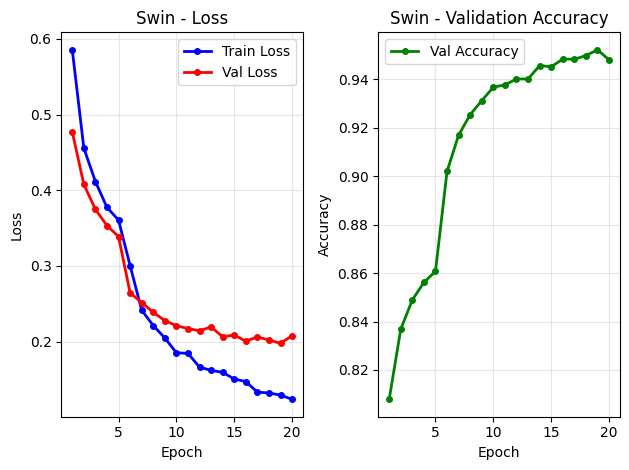


===== EPOCH 21/30 =====

Training swin for Epoch 21...
  Current LRs for swin:
    Group 'swin_backbone': 7.03e-07
    Group 'swin_head': 2.33e-06


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch 21 | Batch 50/1058 | Loss 0.083028


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 21 | Batch 100/1058 | Loss 0.058481


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch 21 | Batch 150/1058 | Loss 0.041045


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 21 | Batch 200/1058 | Loss 0.239633


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 21 | Batch 250/1058 | Loss 0.042152


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 21 | Batch 300/1058 | Loss 0.057916


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 21 | Batch 350/1058 | Loss 0.080275


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 21 | Batch 400/1058 | Loss 0.040200


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 21 | Batch 450/1058 | Loss 0.041035


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 21 | Batch 500/1058 | Loss 0.070811
Epoch 21 | Batch 550/1058 | Loss 0.051296
Epoch 21 | Batch 600/1058 | Loss 0.061107
Epoch 21 | Batch 650/1058 | Loss 0.245752
Epoch 21 | Batch 700/1058 | Loss 0.100963
Epoch 21 | Batch 750/1058 | Loss 0.117840
Epoch 21 | Batch 800/1058 | Loss 0.090812
Epoch 21 | Batch 850/1058 | Loss 0.260722
Epoch 21 | Batch 900/1058 | Loss 0.207726
Epoch 21 | Batch 950/1058 | Loss 0.090030
Epoch 21 | Batch 1000/1058 | Loss 0.045260
Epoch 21 | Batch 1050/1058 | Loss 0.045297
Validating swin for Epoch 21...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 21/30 | Train Loss: 0.125863 | Val Acc: 0.950531


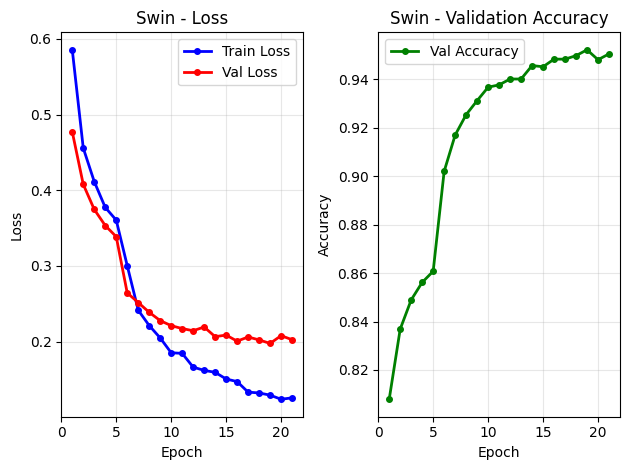


===== EPOCH 22/30 =====

Training swin for Epoch 22...
  Current LRs for swin:
    Group 'swin_backbone': 6.73e-07
    Group 'swin_head': 2.05e-06


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DO

Epoch 22 | Batch 50/1058 | Loss 0.185279


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 22 | Batch 100/1058 | Loss 0.136396


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 22 | Batch 150/1058 | Loss 0.146457


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 22 | Batch 200/1058 | Loss 0.294646


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 22 | Batch 250/1058 | Loss 0.043350


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 22 | Batch 300/1058 | Loss 0.182994


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 22 | Batch 350/1058 | Loss 0.288817


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 22 | Batch 400/1058 | Loss 0.058457
Epoch 22 | Batch 450/1058 | Loss 0.302963


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 22 | Batch 500/1058 | Loss 0.043362
Epoch 22 | Batch 550/1058 | Loss 0.085731
Epoch 22 | Batch 600/1058 | Loss 0.446964
Epoch 22 | Batch 650/1058 | Loss 0.166074
Epoch 22 | Batch 700/1058 | Loss 0.086787


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 22 | Batch 750/1058 | Loss 0.041682
Epoch 22 | Batch 800/1058 | Loss 0.057915
Epoch 22 | Batch 850/1058 | Loss 0.068939
Epoch 22 | Batch 900/1058 | Loss 0.173151
Epoch 22 | Batch 950/1058 | Loss 0.097034


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 22 | Batch 1000/1058 | Loss 0.059799
Epoch 22 | Batch 1050/1058 | Loss 0.049906
Validating swin for Epoch 22...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 22/30 | Train Loss: 0.126354 | Val Acc: 0.952461


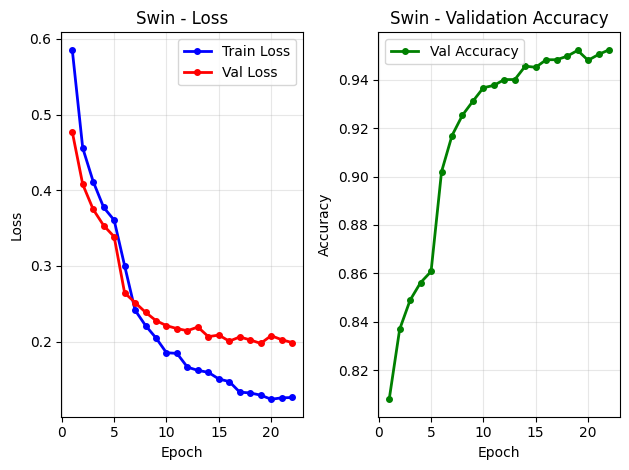


===== EPOCH 23/30 =====

Training swin for Epoch 23...
  Current LRs for swin:
    Group 'swin_backbone': 6.44e-07
    Group 'swin_head': 1.79e-06


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 23 | Batch 50/1058 | Loss 0.036261


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 23 | Batch 100/1058 | Loss 0.043425


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 23 | Batch 150/1058 | Loss 0.085704


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 23 | Batch 200/1058 | Loss 0.076409


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 23 | Batch 250/1058 | Loss 0.119975


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 23 | Batch 300/1058 | Loss 0.044255


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 23 | Batch 350/1058 | Loss 0.129125


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 23 | Batch 400/1058 | Loss 0.055133


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 23 | Batch 450/1058 | Loss 0.047804


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 23 | Batch 500/1058 | Loss 0.089159
Epoch 23 | Batch 550/1058 | Loss 0.072102
Epoch 23 | Batch 600/1058 | Loss 0.138919
Epoch 23 | Batch 650/1058 | Loss 0.241411
Epoch 23 | Batch 700/1058 | Loss 0.090564
Epoch 23 | Batch 750/1058 | Loss 0.047546


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 23 | Batch 800/1058 | Loss 0.057417
Epoch 23 | Batch 850/1058 | Loss 0.079811
Epoch 23 | Batch 900/1058 | Loss 0.042148
Epoch 23 | Batch 950/1058 | Loss 0.054252
Epoch 23 | Batch 1000/1058 | Loss 0.052682
Epoch 23 | Batch 1050/1058 | Loss 0.160673
Validating swin for Epoch 23...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 23/30 | Train Loss: 0.113952 | Val Acc: 0.951737


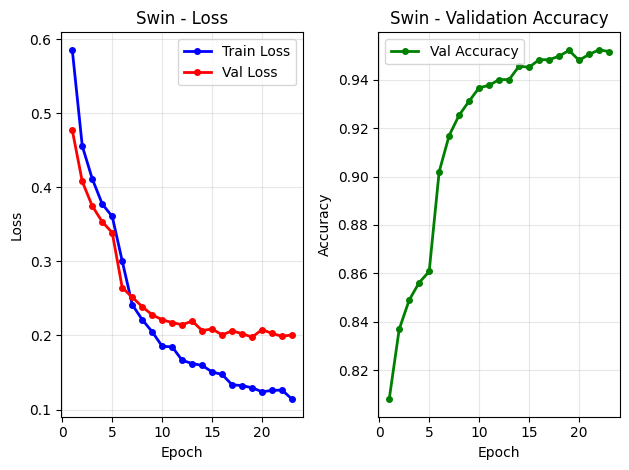


===== EPOCH 24/30 =====

Training swin for Epoch 24...
  Current LRs for swin:
    Group 'swin_backbone': 6.16e-07
    Group 'swin_head': 1.54e-06


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch 24 | Batch 50/1058 | Loss 0.194956


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch 24 | Batch 100/1058 | Loss 0.038870


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 24 | Batch 150/1058 | Loss 0.053606


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 24 | Batch 200/1058 | Loss 0.038204


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 24 | Batch 250/1058 | Loss 0.076571


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 24 | Batch 300/1058 | Loss 0.110718


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 24 | Batch 350/1058 | Loss 0.543228


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 24 | Batch 400/1058 | Loss 0.052140
Epoch 24 | Batch 450/1058 | Loss 0.375513


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 24 | Batch 500/1058 | Loss 0.048394


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 24 | Batch 550/1058 | Loss 0.101475
Epoch 24 | Batch 600/1058 | Loss 0.037480
Epoch 24 | Batch 650/1058 | Loss 0.129137
Epoch 24 | Batch 700/1058 | Loss 0.285712


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 24 | Batch 750/1058 | Loss 0.036928
Epoch 24 | Batch 800/1058 | Loss 0.052452
Epoch 24 | Batch 850/1058 | Loss 0.041405
Epoch 24 | Batch 900/1058 | Loss 0.036574


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 24 | Batch 950/1058 | Loss 0.082565
Epoch 24 | Batch 1000/1058 | Loss 0.038061
Epoch 24 | Batch 1050/1058 | Loss 0.045677
Validating swin for Epoch 24...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 24/30 | Train Loss: 0.109900 | Val Acc: 0.951979


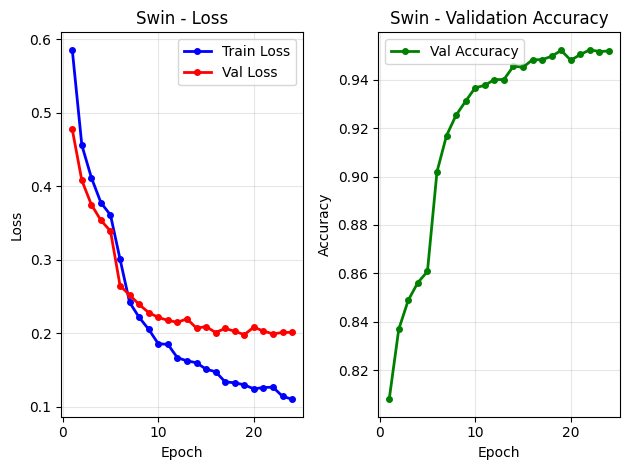


===== EPOCH 25/30 =====

Training swin for Epoch 25...
  Current LRs for swin:
    Group 'swin_backbone': 5.91e-07
    Group 'swin_head': 1.32e-06


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch 25 | Batch 50/1058 | Loss 0.208812


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 25 | Batch 100/1058 | Loss 0.121859


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 25 | Batch 150/1058 | Loss 0.189190
Epoch 25 | Batch 200/1058 | Loss 0.083912


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 25 | Batch 250/1058 | Loss 0.048197


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 25 | Batch 300/1058 | Loss 0.333864
Epoch 25 | Batch 350/1058 | Loss 0.188863


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 25 | Batch 400/1058 | Loss 0.305085


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 25 | Batch 450/1058 | Loss 0.055896


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 25 | Batch 500/1058 | Loss 0.068939


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 25 | Batch 550/1058 | Loss 0.166219


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 25 | Batch 600/1058 | Loss 0.075454
Epoch 25 | Batch 650/1058 | Loss 0.049763


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 25 | Batch 700/1058 | Loss 0.366494
Epoch 25 | Batch 750/1058 | Loss 0.037408
Epoch 25 | Batch 800/1058 | Loss 0.035852
Epoch 25 | Batch 850/1058 | Loss 0.046327
Epoch 25 | Batch 900/1058 | Loss 0.040916
Epoch 25 | Batch 950/1058 | Loss 0.050105
Epoch 25 | Batch 1000/1058 | Loss 0.050523
Epoch 25 | Batch 1050/1058 | Loss 0.044312
Validating swin for Epoch 25...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 25/30 | Train Loss: 0.110592 | Val Acc: 0.952220


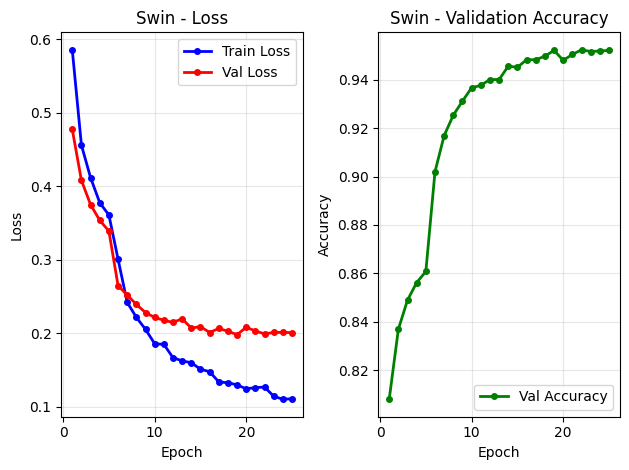


===== EPOCH 26/30 =====

Training swin for Epoch 26...
  Current LRs for swin:
    Group 'swin_backbone': 5.68e-07
    Group 'swin_head': 1.11e-06


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 26 | Batch 50/1058 | Loss 0.107195


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 26 | Batch 100/1058 | Loss 0.198109


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 26 | Batch 150/1058 | Loss 0.149043


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 26 | Batch 200/1058 | Loss 0.152914


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 26 | Batch 250/1058 | Loss 0.067939


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 26 | Batch 300/1058 | Loss 0.121416


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 26 | Batch 350/1058 | Loss 0.045175
Epoch 26 | Batch 400/1058 | Loss 0.043495


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 26 | Batch 450/1058 | Loss 0.042747


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 26 | Batch 500/1058 | Loss 0.044310
Epoch 26 | Batch 550/1058 | Loss 0.053261
Epoch 26 | Batch 600/1058 | Loss 0.191239
Epoch 26 | Batch 650/1058 | Loss 0.055794
Epoch 26 | Batch 700/1058 | Loss 0.037469
Epoch 26 | Batch 750/1058 | Loss 0.070195
Epoch 26 | Batch 800/1058 | Loss 0.182421
Epoch 26 | Batch 850/1058 | Loss 0.038495
Epoch 26 | Batch 900/1058 | Loss 0.092780
Epoch 26 | Batch 950/1058 | Loss 0.056547


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 26 | Batch 1000/1058 | Loss 0.126437
Epoch 26 | Batch 1050/1058 | Loss 0.076058
Validating swin for Epoch 26...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 26/30 | Train Loss: 0.111659 | Val Acc: 0.952703


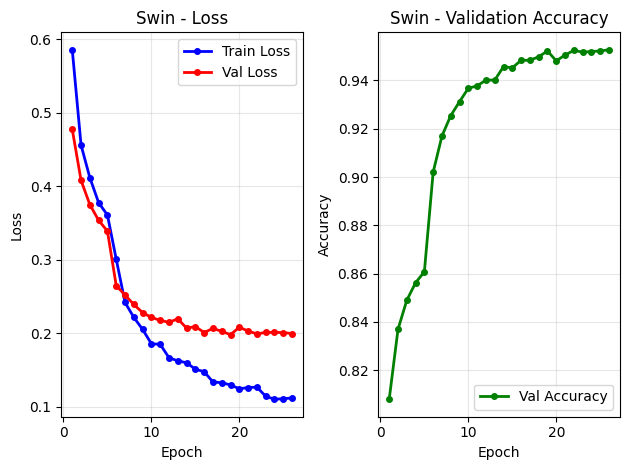


===== EPOCH 27/30 =====

Training swin for Epoch 27...
  Current LRs for swin:
    Group 'swin_backbone': 5.48e-07
    Group 'swin_head': 9.30e-07


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch 27 | Batch 50/1058 | Loss 0.251117


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 27 | Batch 100/1058 | Loss 0.069089


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 27 | Batch 150/1058 | Loss 0.342453


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

Epoch 27 | Batch 200/1058 | Loss 0.086217
Epoch 27 | Batch 250/1058 | Loss 0.055496


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 27 | Batch 300/1058 | Loss 0.039304


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 27 | Batch 350/1058 | Loss 0.289802


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 27 | Batch 400/1058 | Loss 0.089434


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 27 | Batch 450/1058 | Loss 0.338090


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 27 | Batch 500/1058 | Loss 0.090177
Epoch 27 | Batch 550/1058 | Loss 0.042038
Epoch 27 | Batch 600/1058 | Loss 0.111546
Epoch 27 | Batch 650/1058 | Loss 0.077030
Epoch 27 | Batch 700/1058 | Loss 0.040843
Epoch 27 | Batch 750/1058 | Loss 0.054469
Epoch 27 | Batch 800/1058 | Loss 0.051706


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 27 | Batch 850/1058 | Loss 0.092830
Epoch 27 | Batch 900/1058 | Loss 0.049192
Epoch 27 | Batch 950/1058 | Loss 0.050793
Epoch 27 | Batch 1000/1058 | Loss 0.096401
Epoch 27 | Batch 1050/1058 | Loss 0.043466
Validating swin for Epoch 27...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 27/30 | Train Loss: 0.109739 | Val Acc: 0.953427


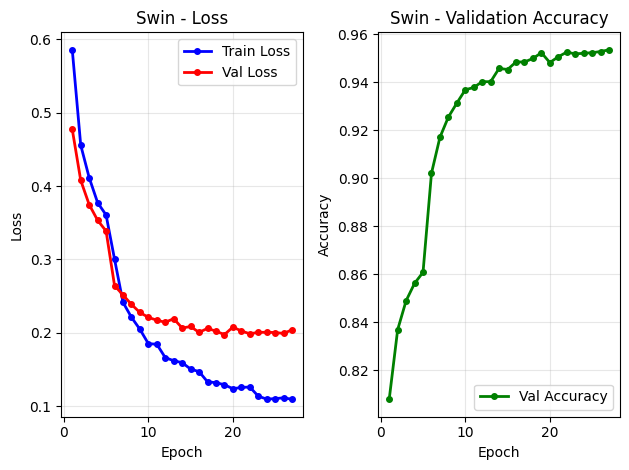


===== EPOCH 28/30 =====

Training swin for Epoch 28...
  Current LRs for swin:
    Group 'swin_backbone': 5.31e-07
    Group 'swin_head': 7.78e-07


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch 28 | Batch 50/1058 | Loss 0.099233


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 28 | Batch 100/1058 | Loss 0.338567


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 28 | Batch 150/1058 | Loss 0.038241


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 28 | Batch 200/1058 | Loss 0.065906


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 28 | Batch 250/1058 | Loss 0.041708


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 28 | Batch 300/1058 | Loss 0.055706


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 28 | Batch 350/1058 | Loss 0.065000


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 28 | Batch 400/1058 | Loss 0.042788
Epoch 28 | Batch 450/1058 | Loss 0.147206
Epoch 28 | Batch 500/1058 | Loss 0.099557
Epoch 28 | Batch 550/1058 | Loss 0.245634
Epoch 28 | Batch 600/1058 | Loss 0.055952


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 28 | Batch 650/1058 | Loss 0.180642


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 28 | Batch 700/1058 | Loss 0.260673


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 28 | Batch 750/1058 | Loss 0.050605
Epoch 28 | Batch 800/1058 | Loss 0.114723


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 28 | Batch 850/1058 | Loss 0.048442
Epoch 28 | Batch 900/1058 | Loss 0.040371
Epoch 28 | Batch 950/1058 | Loss 0.038170
Epoch 28 | Batch 1000/1058 | Loss 0.177302
Epoch 28 | Batch 1050/1058 | Loss 0.097065
Validating swin for Epoch 28...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 28/30 | Train Loss: 0.108172 | Val Acc: 0.953668


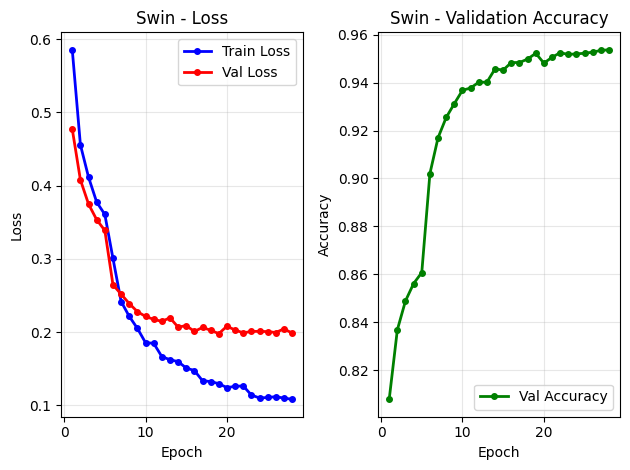


===== EPOCH 29/30 =====

Training swin for Epoch 29...
  Current LRs for swin:
    Group 'swin_backbone': 5.18e-07
    Group 'swin_head': 6.58e-07


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 29 | Batch 50/1058 | Loss 0.042190


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch 29 | Batch 100/1058 | Loss 0.098304


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 29 | Batch 150/1058 | Loss 0.041921


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb

Epoch 29 | Batch 200/1058 | Loss 0.044996


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 29 | Batch 250/1058 | Loss 0.038940


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 29 | Batch 300/1058 | Loss 0.044184


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 29 | Batch 350/1058 | Loss 0.053670


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 29 | Batch 400/1058 | Loss 0.048999
Epoch 29 | Batch 450/1058 | Loss 0.154370


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 29 | Batch 500/1058 | Loss 0.039345


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 29 | Batch 550/1058 | Loss 0.401857


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 29 | Batch 600/1058 | Loss 0.044519
Epoch 29 | Batch 650/1058 | Loss 0.346586
Epoch 29 | Batch 700/1058 | Loss 0.054876
Epoch 29 | Batch 750/1058 | Loss 0.038725
Epoch 29 | Batch 800/1058 | Loss 0.075046


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 29 | Batch 850/1058 | Loss 0.036039
Epoch 29 | Batch 900/1058 | Loss 0.288651
Epoch 29 | Batch 950/1058 | Loss 0.058705
Epoch 29 | Batch 1000/1058 | Loss 0.053044
Epoch 29 | Batch 1050/1058 | Loss 0.083979
Validating swin for Epoch 29...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 29/30 | Train Loss: 0.105856 | Val Acc: 0.954392


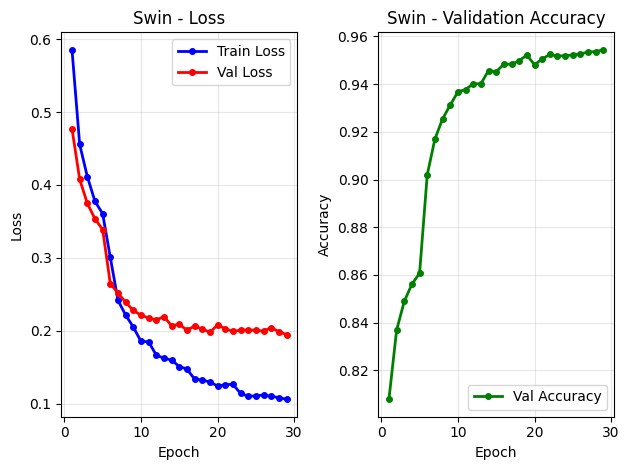


===== EPOCH 30/30 =====

Training swin for Epoch 30...
  Current LRs for swin:
    Group 'swin_backbone': 5.08e-07
    Group 'swin_head': 5.71e-07


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 

Epoch 30 | Batch 50/1058 | Loss 0.144955


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 30 | Batch 100/1058 | Loss 0.277034


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (133516096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 30 | Batch 150/1058 | Loss 0.038951
Epoch 30 | Batch 200/1058 | Loss 0.146418


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 30 | Batch 250/1058 | Loss 0.130995


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 30 | Batch 300/1058 | Loss 0.055224
Epoch 30 | Batch 350/1058 | Loss 0.377604


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 30 | Batch 400/1058 | Loss 0.036922


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 30 | Batch 450/1058 | Loss 0.034209


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (112983393 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 30 | Batch 500/1058 | Loss 0.048031


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 30 | Batch 550/1058 | Loss 0.109412
Epoch 30 | Batch 600/1058 | Loss 0.039136


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (137532423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103264824 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (165340970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 30 | Batch 650/1058 | Loss 0.152400
Epoch 30 | Batch 700/1058 | Loss 0.111703


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (152305056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99827000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 30 | Batch 750/1058 | Loss 0.036764


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99895057 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 30 | Batch 800/1058 | Loss 0.042789
Epoch 30 | Batch 850/1058 | Loss 0.037017
Epoch 30 | Batch 900/1058 | Loss 0.081368
Epoch 30 | Batch 950/1058 | Loss 0.105588
Epoch 30 | Batch 1000/1058 | Loss 0.056724
Epoch 30 | Batch 1050/1058 | Loss 0.038347
Validating swin for Epoch 30...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RESULTS: swin | Epoch 30/30 | Train Loss: 0.097574 | Val Acc: 0.953185


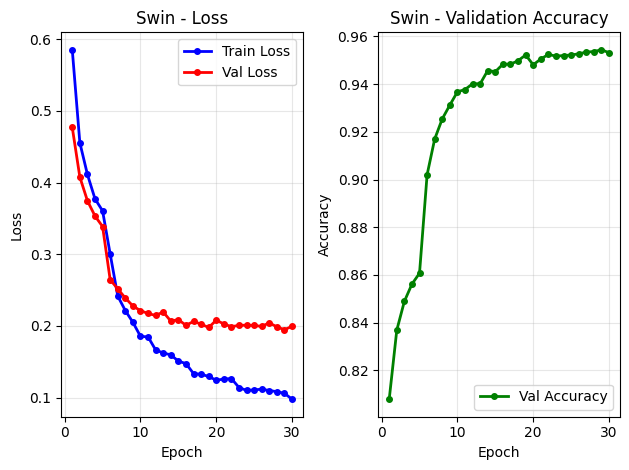


--- Saving Training Results ---
Detailed results saved to /kaggle/working/Training Data/efficientnet_results_2025-09-17_03-53-02_run7.json
Detailed results saved to /kaggle/working/Training Data/swin_results_2025-09-17_03-53-02_run7.json

--- Training complete. Results saved. ---


In [9]:
# import torch
# from timm.scheduler import CosineLRScheduler
# from datetime import datetime
# import os
# import json
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import defaultdict
import torch.optim # For torch.optim.lr_scheduler.ReduceLROnPlateau

def eval_dataset_with_loss(model, loader, loss_fn):
    model.eval()
    group_logits = defaultdict(list)
    group_labels = {}
    total_loss = 0
    total_samples = 0
    
    with torch.no_grad():
        for x, y, pid in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            
            # Calculate loss for this batch
            batch_loss = loss_fn(logits, y)
            total_loss += batch_loss.item() * x.size(0)
            total_samples += x.size(0)
            
            # Continue with painting-level aggregation
            logits_cpu = logits.cpu()
            for lg, yy, id_ in zip(logits_cpu, y.cpu(), pid):
                group_logits[id_].append(lg)
                group_labels[id_] = int(yy)

    # Calculate average loss
    avg_loss = total_loss / total_samples

    # Class balance print
    y_true = list(group_labels.values())

    # Compute painting-level accuracy
    y_pred = [int(torch.stack(lgs).mean(0).argmax()) for lgs in group_logits.values()]
    acc = sum(yt==yp for yt, yp in zip(y_true, y_pred)) / len(y_true)
    
    return acc, avg_loss

# --- ASSUMPTIONS ---
# - 'models': dictionary containing your initialized models, including models['swin']
# - 'optimizers': dictionary with optimizers. optimizers['swin'] MUST have been
#   configured with two parameter groups:
#   {'params': backbone_params, 'lr': SWIN_LR_BACKBONE_FROZEN, 'name': 'swin_backbone'}
#   {'params': head_params, 'lr': SWIN_LR_HEAD_FROZEN, 'name': 'swin_head'}
#   and backbone params initially set to requires_grad=False.
# - 'device': torch.device configured (e.g., "mps", "cuda", "cpu")
# - 'train_loader', 'val_loader': DataLoader instances
# - 'loss_fn': Your loss function (e.g., CrossEntropyLoss)
# - 'train_one_epoch': Function to train for one epoch
# - 'eval_dataset': Function to evaluate on the validation set.
# - 'save_training_results': Function to save metrics.

# --- Configuration ---
EPOCHS = 30  # Total number of epochs to train
# N_FREEZE_EPOCHS_SWIN: Unfreeze Swin backbone *before* starting this epoch (0-indexed).
# If 2, epochs 0 and 1 run frozen, unfreeze for epoch 2.
N_FREEZE_EPOCHS_SWIN = 5
PATIENCE_REDUCE_LR = 5  # For ReduceLROnPlateau scheduler (e.g., for EfficientNet)

# --- Learning Rate Definitions ---
# For Swin Transformer
SWIN_LR_HEAD_FROZEN = 3e-5
SWIN_LR_BACKBONE_FROZEN = 0.0  # Backbone is frozen initially

SWIN_LR_HEAD_FINETUNE = 5e-6 #changed
SWIN_LR_BACKBONE_FINETUNE = 1e-6 #changed
SWIN_LR_MIN_FINETUNE = 5e-7 #changed  lr_min for CosineLRScheduler during fine-tuning

# For EfficientNet (or other models not using DLR in this specific way)
EFFNET_LR_INITIAL = 1e-6 #changed

# --- Learning Rate Schedulers ---
print("--- Configuring Schedulers ---")
schedulers = {}
for name_sched in models.keys():
    if name_sched == 'swin':
        # Swin scheduler will be initialized LATER, when unfreezing
        schedulers[name_sched] = None 
        print(f"  Scheduler for '{name_sched}' will be initialized during unfreeze.")
    else: # For EfficientNet or other models
        if name_sched in optimizers:
            schedulers[name_sched] = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizers[name_sched],
                mode='min', # Monitors loss; use 'max' for accuracy
                factor=0.5,
                patience=PATIENCE_REDUCE_LR,
                verbose=True
            )
            print(f"  Configured ReduceLROnPlateau for '{name_sched}'.")
        else:
            print(f"  WARNING: Optimizer for '{name_sched}' not found. Cannot configure scheduler.")
print("--- Schedulers configured ---")

# Add weight decay to Swin optimizer
if 'swin' in optimizers:
    for param_group in optimizers['swin'].param_groups:
        param_group['weight_decay'] = 0.01

# --- Metrics and State Tracking ---
train_metrics = {name_metrics: [] for name_metrics in models.keys()}
val_metrics = {name_metrics: [] for name_metrics in models.keys()}
val_loss_metrics = {name_metrics: [] for name_metrics in models.keys()}
# If you also track validation loss:
# val_loss_metrics = {name_metrics: [] for name_metrics in models.keys()}

SWIN_IS_UNFROZEN = False
swin_finetune_scheduler_step_count = 0


# --- Verify/Enforce Initial Swin Model State (Backbone Frozen) ---
print("\n--- Verifying Initial Swin Model State (Pre-Epoch 0) ---")
if 'swin' in models and 'swin' in optimizers:
    swin_model_for_init_check = models['swin']
    swin_optimizer_for_init_check = optimizers['swin']
    
    try:
        print(f"  Checking requires_grad for Swin model params...")
        # Assuming 'head' attribute exists for Swin model
        swin_head_param_ids_init = {id(p) for p in swin_model_for_init_check.head.parameters()}
        
        for param_name, param in swin_model_for_init_check.named_parameters():
            is_head_param = id(param) in swin_head_param_ids_init
            if not is_head_param: # Backbone parameter
                if param.requires_grad:
                    print(f"    WARNING: Swin backbone param '{param_name}' has requires_grad=True. Setting to False.")
                    param.requires_grad = False
            else: # Head parameter
                if not param.requires_grad:
                    print(f"    WARNING: Swin head param '{param_name}' has requires_grad=False. Setting to True.")
                    param.requires_grad = True
        
        print(f"  Verifying Swin optimizer groups LRs and param_requires_grad...")
        for group in swin_optimizer_for_init_check.param_groups:
            group_name = group.get('name')
            if group_name == 'swin_backbone':
                if group['lr'] != SWIN_LR_BACKBONE_FROZEN:
                    print(f"    WARNING: Swin backbone group LR is {group['lr']}. Setting to {SWIN_LR_BACKBONE_FROZEN}.")
                    group['lr'] = SWIN_LR_BACKBONE_FROZEN
                for p_opt in group['params']: # Enforce requires_grad for optimizer params
                    if p_opt.requires_grad: p_opt.requires_grad = False 
            elif group_name == 'swin_head':
                if group['lr'] != SWIN_LR_HEAD_FROZEN:
                    print(f"    WARNING: Swin head group LR is {group['lr']}. Setting to {SWIN_LR_HEAD_FROZEN}.")
                    group['lr'] = SWIN_LR_HEAD_FROZEN
                for p_opt in group['params']: # Enforce requires_grad for optimizer params
                     if not p_opt.requires_grad: p_opt.requires_grad = True
        print("  Swin initial state verification complete.")
    except AttributeError:
        print("  WARNING: Could not access models['swin'].head for precise initial state verification. Check model structure.")
    except Exception as e:
        print(f"  ERROR during Swin initial state verification: {e}")
else:
    print("  Swin model or optimizer not found for initial state verification.")


print(f"\n--- Starting Training for {EPOCHS} Epochs ---")
# Training Loop
for epoch in range(EPOCHS):
    print(f"\n===== EPOCH {epoch + 1}/{EPOCHS} =====")

    # --- Differential Learning Rate: Unfreeze Swin Backbone & Adjust LRs ---
    if 'swin' in models and epoch == N_FREEZE_EPOCHS_SWIN and not SWIN_IS_UNFROZEN:
        print(f"\n-- Epoch {epoch + 1}: Unfreezing Swin Transformer backbone and adjusting LRs for fine-tuning. --")
        
        swin_model_to_unfreeze = models['swin']
        swin_optimizer_to_adjust = optimizers['swin']

        # 1. Set requires_grad = True for ALL Swin parameters
        print("  Setting requires_grad=True for all Swin model parameters...")
        for param_name, param in swin_model_to_unfreeze.named_parameters():
            if not param.requires_grad:
                param.requires_grad = True
        print("    All Swin model parameters set to requires_grad=True.")

        # 2. Adjust LRs in the Swin optimizer's parameter groups
        if swin_optimizer_to_adjust:
            updated_lr_swin_backbone_group = False
            updated_lr_swin_head_group = False
            for param_group in swin_optimizer_to_adjust.param_groups:
                group_name = param_group.get('name', 'unknown_group')
                
                # Ensure params in optimizer group also reflect requires_grad=True
                for p_opt_unfreeze in param_group['params']:
                    if not p_opt_unfreeze.requires_grad: p_opt_unfreeze.requires_grad = True

                if group_name == 'swin_backbone':
                    param_group['lr'] = SWIN_LR_BACKBONE_FINETUNE
                    updated_lr_swin_backbone_group = True
                    print(f"  LR for Swin group '{group_name}' set to: {SWIN_LR_BACKBONE_FINETUNE:.2e}")
                elif group_name == 'swin_head':
                    param_group['lr'] = SWIN_LR_HEAD_FINETUNE
                    updated_lr_swin_head_group = True
                    print(f"  LR for Swin group '{group_name}' set to: {SWIN_LR_HEAD_FINETUNE:.2e}")
                elif len(swin_optimizer_to_adjust.param_groups) == 1: # Fallback for single group optimizer
                    print(f"  Swin optimizer has only one group ('{group_name}'). Applying head fine-tune LR: {SWIN_LR_HEAD_FINETUNE:.2e}")
                    param_group['lr'] = SWIN_LR_HEAD_FINETUNE
                    updated_lr_swin_head_group = True 
                else:
                    print(f"  Warning: Unrecognized group name '{group_name}' in Swin optimizer during DLR adjustment.")
            
            if (updated_lr_swin_backbone_group and updated_lr_swin_head_group) or \
               (updated_lr_swin_head_group and len(swin_optimizer_to_adjust.param_groups) == 1):
                print("  Successfully updated LRs for Swin optimizer groups.")

                # 3. Initialize the CosineLRScheduler for Swin NOW
                print("  Initializing CosineLRScheduler for Swin fine-tuning...")
                remaining_epochs_for_swin = EPOCHS - epoch
                schedulers['swin'] = CosineLRScheduler(
                    swin_optimizer_to_adjust,
                    t_initial=remaining_epochs_for_swin,
                    warmup_t=1,                            # 1 epoch of warmup
                    warmup_lr_init=SWIN_LR_BACKBONE_FINETUNE,  # start warmup from backbone LR (3e-6)
                    lr_min=SWIN_LR_MIN_FINETUNE
                )
                print(f"  Swin CosineLRScheduler initialized for {remaining_epochs_for_swin} fine-tuning epochs.")
                SWIN_IS_UNFROZEN = True
                swin_finetune_scheduler_step_count = 0 # Reset step count for the new scheduler
            else:
                print("  WARNING: Could not reliably update Swin DLRs. Check optimizer group names ('swin_backbone', 'swin_head'). Swin scheduler NOT initialized.")
        else:
            print("  Swin optimizer not found. Cannot adjust LRs or initialize scheduler for fine-tuning.")
        print("-- Swin unfreezing and LR adjustment complete. --")
    elif 'swin' in models and epoch >= N_FREEZE_EPOCHS_SWIN and not SWIN_IS_UNFROZEN:
        print(f"  WARNING: Swin should be unfrozen by epoch {epoch+1} but SWIN_IS_UNFROZEN is False. Check logic.")


    # --- Iterate through models for training and validation ---
    for model_name_loop in models.keys():
        if model_name_loop == 'swin':
            current_model_train = models[model_name_loop]
            current_optimizer_train = optimizers[model_name_loop]
            # current_scheduler_train will be None for Swin until unfrozen
            current_scheduler_train = schedulers.get(model_name_loop) 
    
            print(f"\nTraining {model_name_loop} for Epoch {epoch + 1}...")
            if current_optimizer_train:
                print(f"  Current LRs for {model_name_loop}:")
                for i, param_group_disp in enumerate(current_optimizer_train.param_groups):
                    group_display_name = param_group_disp.get('name', f'group_{i}')
                    print(f"    Group '{group_display_name}': {param_group_disp['lr']:.2e}")
            
            train_loss_epoch, _, _ = train_one_epoch(
                current_model_train,
                train_loader,
                current_optimizer_train,
                epoch,
                print_every=50
            )
    
            # Apply gradient clipping
            if current_optimizer_train:
                torch.nn.utils.clip_grad_norm_(current_model_train.parameters(), max_norm=1.0)
    
            print(f"Validating {model_name_loop} for Epoch {epoch + 1}...")
            val_acc_epoch, val_loss_epoch = eval_dataset_with_loss(current_model_train, val_loader, loss_fn)
            # val_loss_epoch = None # If eval_dataset doesn't return it

            # Scheduler step
            if current_scheduler_train:
                if model_name_loop == 'swin':
                    if SWIN_IS_UNFROZEN: # Only step Swin scheduler if it's active for fine-tuning
                        current_scheduler_train.step(swin_finetune_scheduler_step_count)
                        # print(f"  Stepped Swin scheduler with fine-tune step {swin_finetune_scheduler_step_count}")
                    # else: Swin scheduler is not active yet or not initialized
                else: # For EfficientNet (ReduceLROnPlateau)
                    # current_scheduler_train.step(val_loss_epoch if val_loss_epoch is not None else train_loss_epoch)
                    current_scheduler_train.step(train_loss_epoch) # Step with train_loss as per your original
            
            log_message = f"RESULTS: {model_name_loop} | Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss_epoch:.6f} | Val Acc: {val_acc_epoch:.6f}"
            print(log_message)
            
            train_metrics[model_name_loop].append(train_loss_epoch)
            val_metrics[model_name_loop].append(val_acc_epoch)
            val_loss_metrics[model_name_loop].append(val_loss_epoch)

    plt.clf()  # Clear the figure
    
    # for model_idx, model_name in enumerate(models.keys()):
    #     epochs_so_far = list(range(1, epoch + 2))
        
    #     # Create subplots for this model
    #     plt.subplot(len(models), 2, model_idx * 2 + 1)
    #     plt.plot(epochs_so_far, train_metrics[model_name], 'b-o', label='Train Loss', linewidth=2, markersize=4)
    #     plt.plot(epochs_so_far, val_loss_metrics[model_name], 'r-o', label='Val Loss', linewidth=2, markersize=4)
    #     plt.title(f'{model_name.upper()} - Loss')
    #     plt.xlabel('Epoch')
    #     plt.ylabel('Loss')
    #     plt.legend()
    #     plt.grid(True, alpha=0.3)
        
    #     plt.subplot(len(models), 2, model_idx * 2 + 2)
    #     plt.plot(epochs_so_far, val_metrics[model_name], 'g-o', label='Val Accuracy', linewidth=2, markersize=4)
    #     plt.title(f'{model_name.upper()} - Validation Accuracy')
    #     plt.xlabel('Epoch')
    #     plt.ylabel('Accuracy')
    #     plt.legend()
    #     plt.grid(True, alpha=0.3)
    
    # plt.tight_layout()
    # plt.draw()
    # plt.pause(0.1)  # Small pause to update the plot
    epochs_so_far = list(range(1, epoch + 2))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_so_far, train_metrics['swin'], 'b-o', label='Train Loss', linewidth=2, markersize=4)
    plt.plot(epochs_so_far, val_loss_metrics['swin'], 'r-o', label='Val Loss', linewidth=2, markersize=4)
    plt.title('Swin - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_so_far, val_metrics['swin'], 'g-o', label='Val Accuracy', linewidth=2, markersize=4)
    plt.title('Swin - Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.draw()
    plt.pause(0.1)
        
    
    # Increment Swin fine-tune scheduler step count at the END of the outer epoch loop
    if SWIN_IS_UNFROZEN:
        swin_finetune_scheduler_step_count += 1

# --- End of Epoch Loop ---

# Keep the final plot displayed
plt.ioff()  # Turn off interactive mode
plt.show()


# --- End of Epoch Loop ---

print("\n--- Saving Training Results ---")
current_timestamp_str_save = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
for model_name_save_results in models.keys():
    save_training_results(
        model_name_save_results,
        train_metrics[model_name_save_results],
        val_metrics[model_name_save_results],
        current_timestamp_str_save
    )
    # Optionally, save model checkpoints
    # model_save_path = f"../backend/model/{model_name_save_results}_final_epoch{EPOCHS}_{current_timestamp_str_save}.pth"
    # torch.save(models[model_name_save_results].state_dict(), model_save_path)
    # print(f"Saved {model_name_save_results} checkpoint to {model_save_path}")

print("\n--- Training complete. Results saved. ---")

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



=== EFFICIENTNET ===
ROC‐AUC: 0.497   PR‐AUC (AP): 0.486
              precision    recall  f1-score   support

   authentic       0.51      0.39      0.44      2127
   imitation       0.48      0.61      0.54      2017

    accuracy                           0.49      4144
   macro avg       0.50      0.50      0.49      4144
weighted avg       0.50      0.49      0.49      4144



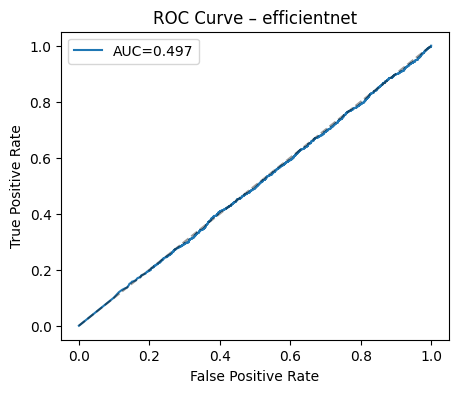

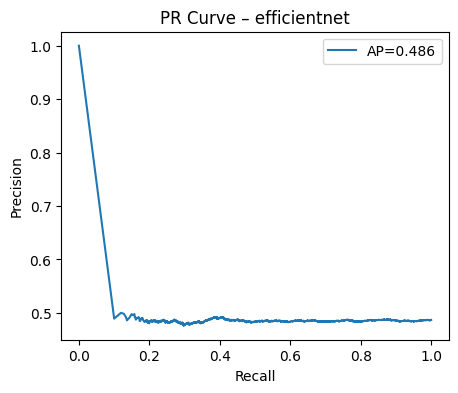

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



=== SWIN ===
ROC‐AUC: 0.985   PR‐AUC (AP): 0.985
              precision    recall  f1-score   support

   authentic       0.96      0.95      0.95      2127
   imitation       0.95      0.96      0.95      2017

    accuracy                           0.95      4144
   macro avg       0.95      0.95      0.95      4144
weighted avg       0.95      0.95      0.95      4144



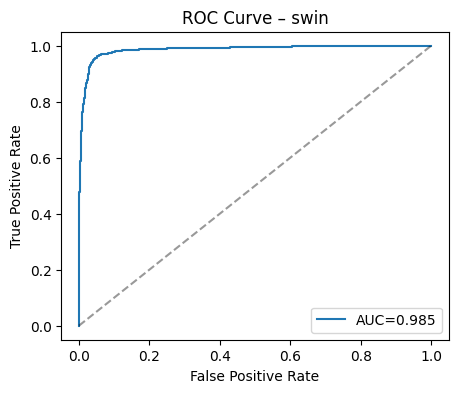

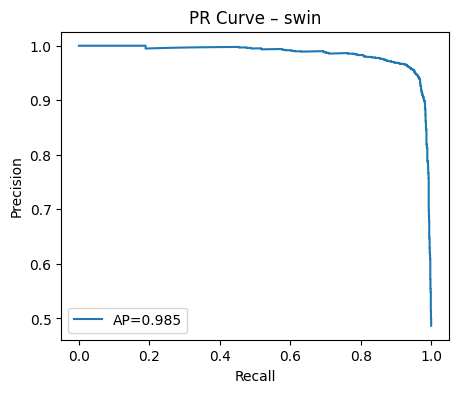

In [10]:
# 9. Detailed Evaluation Metrics & Curves
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve
)
import matplotlib.pyplot as plt
import torch.nn.functional as F

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda")

for name, model in models.items():
    model.to(device).eval()
    y_true, y_scores = [], []

    # Gather ground‐truth & predicted “imitation” probabilities
    with torch.no_grad():
        for x, y, _ in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            probs = F.softmax(logits, dim=1)[:, 1]      # P(imitation)
            y_true.extend(y.cpu().numpy().tolist())
            y_scores.extend(probs.cpu().numpy().tolist())

    # Binarize predictions at 0.5
    y_pred = [1 if p >= 0.5 else 0 for p in y_scores]

    # Compute metrics
    auc = roc_auc_score(y_true, y_scores)
    ap  = average_precision_score(y_true, y_scores)
    print(f"\n=== {name.upper()} ===")
    print(f"ROC‐AUC: {auc:.3f}   PR‐AUC (AP): {ap:.3f}")
    print(classification_report(
        y_true, y_pred,
        target_names=['authentic','imitation']
    ))

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'AUC={auc:.3f}')
    plt.plot([0,1],[0,1],'k--',alpha=0.4)
    plt.title(f'ROC Curve – {name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(); plt.show()

    # Plot Precision–Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(5,4))
    plt.plot(recall, precision, label=f'AP={ap:.3f}')
    plt.title(f'PR Curve – {name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(); plt.show()

## 10. Plotting training metrics for each model
(reads CSV logs and plots train/val loss & val accuracy)

In [11]:
# 8) Painting‐level & Ensemble Evaluation
import numpy as np
import torch.nn.functional as F
from collections import defaultdict, Counter
from sklearn.metrics import classification_report, accuracy_score

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda")
effnet_model = models['efficientnet'].to(device).eval()
swin_model   = models['swin'].to(device).eval()

# 1. Collect patch‐level data
painting_ids, true_labels = [], []
effnet_probs, swin_probs = [], []

for x, y, pid in val_loader:
    x = x.to(device)
    with torch.no_grad():
        e_logits = effnet_model(x)
        s_logits = swin_model(x)
        e_p = F.softmax(e_logits, dim=1)[:, 1].cpu().numpy()
        s_p = F.softmax(s_logits, dim=1)[:, 1].cpu().numpy()
    painting_ids.extend(pid.numpy())
    true_labels.extend(y.numpy())
    effnet_probs.extend(e_p)
    swin_probs.extend(s_p)

# 2. Aggregate per painting
paintings = defaultdict(list)
for pid, y, p1, p2 in zip(painting_ids, true_labels, effnet_probs, swin_probs):
    paintings[pid].append((y, p1, p2))

painting_true = []
paint_eff_major = []
paint_swin_major = []
paint_ens_major = []
paint_ens_avg = []

for pid, patches in paintings.items():
    y_true = patches[0][0]
    p1_list = [t[1] for t in patches]
    p2_list = [t[2] for t in patches]
    # votes at 0.5
    v1 = [int(p>=0.5) for p in p1_list]
    v2 = [int(p>=0.5) for p in p2_list]
    # ensemble avg‐prob votes
    avg_probs = [(a+b)/2 for a,b in zip(p1_list, p2_list)]
    v_avg = [int(p>=0.5) for p in avg_probs]

    painting_true.append(y_true)
    paint_eff_major.append(Counter(v1).most_common(1)[0][0])
    paint_swin_major.append(Counter(v2).most_common(1)[0][0])
    paint_ens_major.append(Counter(v_avg).most_common(1)[0][0])
    paint_ens_avg.append(int(np.mean(avg_probs)>=0.5))

# 3. Report metrics
print("=== Painting‐level Metrics ===")
for label, preds in [
    ("EffNet‐majority", paint_eff_major),
    ("Swin‐majority", paint_swin_major),
    ("Ensemble‐majority", paint_ens_major),
    ("Ensemble‐avgprob", paint_ens_avg),
]:
    print(f"\n{label}:")
    print("Accuracy:", accuracy_score(painting_true, preds))
    print(classification_report(
        painting_true, preds,
        target_names=['authentic','imitation']
    ))

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (160308605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (103703352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


=== Painting‐level Metrics ===

EffNet‐majority:
Accuracy: 0.49859154929577465
              precision    recall  f1-score   support

   authentic       0.50      0.31      0.38       177
   imitation       0.50      0.69      0.58       178

    accuracy                           0.50       355
   macro avg       0.50      0.50      0.48       355
weighted avg       0.50      0.50      0.48       355


Swin‐majority:
Accuracy: 0.952112676056338
              precision    recall  f1-score   support

   authentic       0.96      0.94      0.95       177
   imitation       0.94      0.96      0.95       178

    accuracy                           0.95       355
   macro avg       0.95      0.95      0.95       355
weighted avg       0.95      0.95      0.95       355


Ensemble‐majority:
Accuracy: 0.780281690140845
              precision    recall  f1-score   support

   authentic       0.87      0.66      0.75       177
   imitation       0.73      0.90      0.81       178

    accurac

## 11. Saving metrics for each model


In [12]:
import os, json
import matplotlib.pyplot as plt

for model_name in models:
    json_path = f"/kaggle/working/Training Data/{model_name}_results_{now_str}.json"
    if not os.path.exists(json_path):
        print(f"No JSON results for {model_name} at {json_path}")
        continue

    # load our JSON list of dicts
    with open(json_path) as f:
        results = json.load(f)

    train_loss = results["training"]
    val_acc    = results["validation"]
    epochs     = list(range(1, len(train_loss)+1))

    plt.plot(epochs, train_loss, label="train loss")
    plt.plot(epochs, val_acc,    label="val acc")
    plt.legend()
    plt.show()

    #epochs = [r["epoch"] for r in results["training"]]
    #train_loss = [r["loss"]  for r in results["training"]]
    #val_acc    = [r["acc"]   for r in results["validation"]]

    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    ax = axes[0]
    ax.plot(epochs, train_loss, '-o', label="Train Loss")
    ax.set_title(f"{model_name} – Train Loss")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Loss")
    ax.grid(True)

    ax = axes[1]
    ax.plot(epochs, val_acc, '-o', color="green", label="Val Acc")
    ax.set_title(f"{model_name} – Val Accuracy")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Accuracy")
    ax.grid(True)

    plt.tight_layout()
    plt.show()

No JSON results for efficientnet at /kaggle/working/Training Data/efficientnet_results_2025-09-16_18-24-09.json
No JSON results for swin at /kaggle/working/Training Data/swin_results_2025-09-16_18-24-09.json


## 12. Saving models

In [13]:
import os
import torch

# Ensure the save directory exists
for path in model_save_paths.values():
    os.makedirs(os.path.dirname(path), exist_ok=True)

# Save each model after training
for name, model in models.items():
    torch.save(model.state_dict(), model_save_paths[name])
    print(f"Model weights saved to {model_save_paths[name]}")

Model weights saved to /kaggle/working/model/efficientnet_b5_finetuned_2025-09-16_18-24-09_run7.pth
Model weights saved to /kaggle/working/model/swin_tiny_patch4_window7_224_finetuned_2025-09-16_18-24-09_run7.pth
